# Importazione del Dataset e Creazione del DB in Neo4J

In [22]:
from neo4j import GraphDatabase
import logging 
logging.getLogger("neo4j").setLevel(logging.ERROR)

uri = 'bolt://localhost:7687'
user = 'neo4j'
password = 'nbadataset'
db_name = 'nba'

driver = GraphDatabase.driver(uri,auth=(user,password))
driver.verify_connectivity()
print('connessione a neo4j riuscita!')

with driver.session(database=db_name) as session:
    print(f'Sessione aperta con successo al database: {db_name}')
    result = session.run("MATCH (n) RETURN count(n) AS node_count")
    record = result.single() # singolo record test


connessione a neo4j riuscita!
Sessione aperta con successo al database: nba


Importazione delle squadre 

In [ ]:
import pandas as pd
df = pd.read_csv('teams_for_neo4j.csv')
df.info()

In [5]:
# --- Funzione per creare Constraints ---
def create_constraints_for_schema(neo4j_session):
    print("Tentativo di creazione constraints...")
    neo4j_session.run("""
        CREATE CONSTRAINT IF NOT EXISTS FOR (t:Team)
        REQUIRE t.teamId IS UNIQUE;
    """)
    print("Constraints per :Team creati (o già esistenti).")

# --- Funzione per importare le Squadre ---
def import_teams_data(neo4j_session, csv_filename="teams_for_neo4j.csv"):
    print(f"Inizio importazione squadre da '{csv_filename}'...")
    
    import_query = """
    LOAD CSV WITH HEADERS FROM $csvFileUrl AS row // csvFileUrl -> alias per accedere al file in 'import' 
    FIELDTERMINATOR ','
    MERGE (t:Team {teamId: toInteger(row.TEAM_ID)})
    ON CREATE SET
        t.leagueId = toInteger(row.LEAGUE_ID),
        t.minYear = toInteger(row.MIN_YEAR),
        t.maxYear = toInteger(row.MAX_YEAR),
        t.abbreviation = row.ABBREVIATION,
        t.nickname = row.NICKNAME,
        t.yearFounded = toInteger(row.YEARFOUNDED),
        t.city = row.CITY,
        t.arena = row.ARENA,
        t.owner = row.OWNER,
        t.generalManager = row.GENERALMANAGER,
        t.headCoach = row.HEADCOACH,
        t.dLeagueAffiliation = row.DLEAGUEAFFILIATION
    ON MATCH SET
        t.leagueId = toInteger(row.LEAGUE_ID),
        t.minYear = toInteger(row.MIN_YEAR),
        t.maxYear = toInteger(row.MAX_YEAR),
        t.abbreviation = row.ABBREVIATION,
        t.nickname = row.NICKNAME,
        t.yearFounded = toInteger(row.YEARFOUNDED),
        t.city = row.CITY,
        t.arena = row.ARENA,
        t.owner = row.OWNER,
        t.generalManager = row.GENERALMANAGER,
        t.headCoach = row.HEADCOACH,
        t.dLeagueAffiliation = row.DLEAGUEAFFILIATION
    """
    
    # URL del file per Neo4j, protocollo 'file:///'
    file_url_for_neo4j = 'file:///' + csv_filename
    
    neo4j_session.run(import_query, csvFileUrl=file_url_for_neo4j)
    print(f"Importazione squadre da '{csv_filename}' (usando URL: {file_url_for_neo4j}) completata.")

# --- Esecuzione delle operazioni nel contesto della sessione Neo4j ---
try:
    with driver.session(database=db_name) as session:
        print(f"Utilizzo della sessione esistente con il database: '{db_name}' per l'importazione.")
        
        # 1. Crea i constraints 
        create_constraints_for_schema(session)
        
        # 2. Importa le squadre
        import_teams_data(session, csv_filename="teams_for_neo4j.csv")
        
        # 3. Verifica il numero di nodi Team creati
        result = session.run("MATCH (t:Team) RETURN count(t) AS team_count")
        count_record = result.single()
        if count_record:
            print(f"Numero totale di nodi :Team nel database '{db_name}': {count_record['team_count']}")
        else:
            print(f"Nessun nodo :Team trovato dopo l'importazione.")

except Exception as e:
    print(f"Si è verificato un errore durante le operazioni con Neo4j: {e}")
    print("Controlla i messaggi di errore per dettagli specifici.")


Utilizzo della sessione esistente con il database: 'nba' per l'importazione.
Inizio importazione squadre da 'teams_for_neo4j.csv'...
Importazione squadre da 'teams_for_neo4j.csv' (usando URL: file:///teams_for_neo4j.csv) completata.
Numero totale di nodi :Team nel database 'nba': 30


In [10]:
df_players = pd.read_csv('players_for_neo4j.csv')

unique_player_ids = df_players['PLAYER_ID'].nunique()
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7228 entries, 0 to 7227
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PLAYER_NAME  7228 non-null   object
 1   TEAM_ID      7228 non-null   int64 
 2   PLAYER_ID    7228 non-null   int64 
 3   SEASON       7228 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 226.0+ KB


In [11]:
# --- Funzione per creare Constraints ---
def create_constraints_for_schema(neo4j_session):
    print("Tentativo di creazione constraints...")
    # Constraint per Player
    neo4j_session.run("""
        CREATE CONSTRAINT IF NOT EXISTS FOR (p:Player)
        REQUIRE p.playerId IS UNIQUE;
    """)
    print("Constraints per :Team e :Player creati (o già esistenti).")

# --- Funzione per importare i Giocatori ---
def import_players_data(neo4j_session, csv_filename="players_for_neo4j.csv"):
    print(f"Inizio importazione giocatori da '{csv_filename}'...")
    

    # PLAYER_ID è la chiave univoca per i nodi :Player.
    # PLAYER_NAME -> proprietà.
    import_query = """
    LOAD CSV WITH HEADERS FROM $csvFileUrl AS row
    FIELDTERMINATOR ','
    MERGE (p:Player {playerId: toInteger(row.PLAYER_ID)}) // row.PLAYER_ID è int64
    ON CREATE SET // Imposta il nome solo quando il nodo viene creato la prima volta
        p.name = row.PLAYER_NAME      // row.PLAYER_NAME è object (string)
    """
    
    file_url_for_neo4j = 'file:///' + csv_filename
    
    neo4j_session.run(import_query, csvFileUrl=file_url_for_neo4j)
    print(f"Importazione giocatori da '{csv_filename}' (usando URL: {file_url_for_neo4j}) completata.")

# --- Esecuzione delle operazioni nel contesto della sessione Neo4j ---
try:
    with driver.session(database=db_name) as session:
        print(f"Utilizzo della sessione esistente con il database: '{db_name}' per l'importazione dei giocatori.")
        
        # 1. Aggiorna/Crea i constraints
        create_constraints_for_schema(session) 
        
        # 2. Importa i giocatori
        import_players_data(session, csv_filename="players_for_neo4j.csv")
        
        result = session.run("MATCH (p:Player) RETURN count(p) AS player_count")
        count_record = result.single()
        if count_record:
            print(f"Numero totale di nodi :Player nel database '{db_name}': {count_record['player_count']}")
        else:
            print(f"Nessun nodo :Player trovato dopo l'importazione.")

except Exception as e:
    print(f"Si è verificato un errore durante le operazioni con Neo4j: {e}")


Utilizzo della sessione esistente con il database: 'nba' per l'importazione dei giocatori.
Tentativo di creazione constraints...
Constraints per :Team e :Player creati (o già esistenti).
Inizio importazione giocatori da 'players_for_neo4j.csv'...
Importazione giocatori da 'players_for_neo4j.csv' (usando URL: file:///players_for_neo4j.csv) completata.
Numero totale di nodi :Player nel database 'nba': 1769


Importazione delle partite 

In [ ]:
df_games_filtered = pd.read_csv('games_filtered.csv')
df_games_filtered.info()

In [18]:
# --- Funzione per creare Constraints ---
def create_constraints_for_schema(neo4j_session):
    print("Tentativo di creazione constraints...")
    # Constraint per Game
    neo4j_session.run("""
        CREATE CONSTRAINT IF NOT EXISTS FOR (g:Game)
        REQUIRE g.gameId IS UNIQUE;
    """)
    print("Constraints per :Team, :Player, e :Game creati (o già esistenti).")

# --- Funzione per importare le Partite e creare relazioni con le Squadre ---
def import_games_and_team_relations(neo4j_session, csv_filename="games_filtered.csv"):
    print(f"Inizio importazione partite e relazioni con squadre da '{csv_filename}'...")
    
    # Query Cypher basata sulla struttura del tuo CSV games_filtered.csv
    import_query = """
    LOAD CSV WITH HEADERS FROM $csvFileUrl AS row
    FIELDTERMINATOR ','
    
    // Trova i nodi Team per la squadra di casa e ospite (devono già esistere)
    MATCH (homeTeam:Team {teamId: toInteger(row.HOME_TEAM_ID)})
    MATCH (visitorTeam:Team {teamId: toInteger(row.VISITOR_TEAM_ID)})
    
    // Crea (o fa il merge) del nodo Game
    MERGE (g:Game {gameId: toInteger(row.GAME_ID)})
    ON CREATE SET
        g.date = date(row.GAME_DATE_EST),       // Converte la stringa data in un tipo date di Neo4j
        g.statusText = row.GAME_STATUS_TEXT,
        g.season = toInteger(row.SEASON),
        g.homeTeamWins = CASE WHEN toInteger(row.HOME_TEAM_WINS) = 1 THEN true ELSE false END, // Converte int (0/1) a boolean
        // Statistiche generali della partita come proprietà del nodo Game
        g.ptsHome = toFloat(row.PTS_home),
        g.fgPctHome = toFloat(row.FG_PCT_home),
        g.ftPctHome = toFloat(row.FT_PCT_home),
        g.fg3PctHome = toFloat(row.FG3_PCT_home),
        g.astHome = toFloat(row.AST_home),
        g.rebHome = toFloat(row.REB_home),
        g.ptsAway = toFloat(row.PTS_away),
        g.fgPctAway = toFloat(row.FG_PCT_away),
        g.ftPctAway = toFloat(row.FT_PCT_away),
        g.fg3PctAway = toFloat(row.FG3_PCT_away),
        g.astAway = toFloat(row.AST_away),
        g.rebAway = toFloat(row.REB_away)
        // Le colonne TEAM_ID_home e TEAM_ID_away nel CSV sono ridondanti 
        // se corrispondono a HOME_TEAM_ID e VISITOR_TEAM_ID, quindi non le usiamo direttamente sul nodo Game.
        // Le usiamo per fare il MATCH dei nodi Team.
        
    // Crea le relazioni tra Squadre e Partita
    MERGE (homeTeam)-[:HOSTED_GAME]->(g)
    MERGE (visitorTeam)-[:VISITED_GAME]->(g)
    """
    
    file_url_for_neo4j = 'file:///' + csv_filename
    
    neo4j_session.run(import_query, csvFileUrl=file_url_for_neo4j)
    print(f"Importazione partite e relazioni da '{csv_filename}' (usando URL: {file_url_for_neo4j}) completata.")

# --- Esecuzione delle operazioni nel contesto della sessione Neo4j ---
try:
    with driver.session(database=db_name) as session:
        print(f"Utilizzo della sessione esistente con il database: '{db_name}' per l'importazione delle partite.")
        
        # 1. Crea i constraints 
        create_constraints_for_schema(session) 
        
        # 2. Importa le partite e crea le relazioni con le squadre
        import_games_and_team_relations(session, csv_filename="games_filtered.csv")
        
        # 3. Verifica il numero di nodi Game e relazioni create
        game_count_result = session.run("MATCH (g:Game) RETURN count(g) AS game_count")
        game_count_record = game_count_result.single()
        if game_count_record:
            print(f"Numero totale di nodi :Game nel database '{db_name}': {game_count_record['game_count']}")
        else:
            print(f"Nessun nodo :Game trovato dopo l'importazione.")
            
        hosted_rels_result = session.run("MATCH (:Team)-[r:HOSTED_GAME]->(:Game) RETURN count(r) AS hosted_rels_count")
        hosted_rels_record = hosted_rels_result.single()
        if hosted_rels_record:
            print(f"Numero totale di relazioni :HOSTED_GAME: {hosted_rels_record['hosted_rels_count']}")

        visited_rels_result = session.run("MATCH (:Team)-[r:VISITED_GAME]->(:Game) RETURN count(r) AS visited_rels_count")
        visited_rels_record = visited_rels_result.single()
        if visited_rels_record:
            print(f"Numero totale di relazioni :VISITED_GAME: {visited_rels_record['visited_rels_count']}")


except Exception as e:
    print(f"Si è verificato un errore durante le operazioni con Neo4j: {e}")


Utilizzo della sessione esistente con il database: 'nba' per l'importazione delle partite.
Tentativo di creazione constraints...
Constraints per :Team, :Player, e :Game creati (o già esistenti).
Inizio importazione partite e relazioni con squadre da 'games_filtered.csv'...
Importazione partite e relazioni da 'games_filtered.csv' (usando URL: file:///games_filtered.csv) completata.
Numero totale di nodi :Game nel database 'nba': 6822
Numero totale di relazioni :HOSTED_GAME: 6822
Numero totale di relazioni :VISITED_GAME: 6822


Importazione dettagli delle partite 

In [ ]:
df_game_details = pd.read_csv('games_details_filtered.csv')

df_game_details.info()
df_game_details.isna().sum()

In [28]:
# --- Funzione per importare le Performance dei Giocatori e creare relazioni :PLAYED_IN_GAME ---
def import_player_performances(neo4j_session, csv_filename="games_details_filtered.csv"): 
    print(f"Inizio importazione performance giocatori e creazione relazioni :PLAYED_IN_GAME da '{csv_filename}'...")
    
    import_query = """
    LOAD CSV WITH HEADERS FROM $csvFileUrl AS row
    FIELDTERMINATOR ','
    // Trova i nodi Player e Game
    MATCH (p:Player {playerId: toInteger(row.PLAYER_ID)})
    MATCH (g:Game {gameId: toInteger(row.GAME_ID)})
    // ma TEAM_ID diventa proprietà sulla relazione per semplicità.
    // MATCH (t:Team {teamId: toInteger(row.TEAM_ID)})
    
    // Crea la relazione :PLAYED_IN_GAME con le statistiche
    MERGE (p)-[played_in:PLAYED_IN_GAME]->(g)
    ON CREATE SET // Imposta le proprietà solo la prima volta che questa specifica relazione viene creata
        played_in.teamId = toInteger(row.TEAM_ID), // Squadra per cui il giocatore ha giocato in questa partita
        played_in.teamAbbreviation = row.TEAM_ABBREVIATION, // Utile per riferimento rapido
        played_in.teamCity = row.TEAM_CITY, 
        played_in.startPosition = CASE WHEN row.START_POSITION IS NOT NULL AND trim(row.START_POSITION) <> '' THEN row.START_POSITION ELSE null END,
        played_in.comment = CASE WHEN row.COMMENT IS NOT NULL AND trim(row.COMMENT) <> '' THEN row.COMMENT ELSE null END,
        played_in.minutesPlayed = toInteger(row.MIN_SECONDS), // Usiamo la colonna dei secondi 
        played_in.fgm = coalesce(toFloat(row.FGM), 0.0),
        played_in.fga = coalesce(toFloat(row.FGA), 0.0),
        played_in.fgPct = coalesce(toFloat(row.FG_PCT), 0.0),
        played_in.fg3m = coalesce(toFloat(row.FG3M), 0.0),
        played_in.fg3a = coalesce(toFloat(row.FG3A), 0.0),
        played_in.fg3Pct = coalesce(toFloat(row.FG3_PCT), 0.0),
        played_in.ftm = coalesce(toFloat(row.FTM), 0.0),
        played_in.fta = coalesce(toFloat(row.FTA), 0.0),
        played_in.ftPct = coalesce(toFloat(row.FT_PCT), 0.0),
        played_in.oreb = coalesce(toFloat(row.OREB), 0.0),
        played_in.dreb = coalesce(toFloat(row.DREB), 0.0),
        played_in.reb = coalesce(toFloat(row.REB), 0.0),
        played_in.ast = coalesce(toFloat(row.AST), 0.0),
        played_in.stl = coalesce(toFloat(row.STL), 0.0),
        played_in.blk = coalesce(toFloat(row.BLK), 0.0),
        played_in.turnovers = coalesce(toFloat(row.TO), 0.0),
        played_in.personalFouls = coalesce(toFloat(row.PF), 0.0),
        played_in.points = coalesce(toFloat(row.PTS), 0.0),
        played_in.plusMinus = coalesce(toFloat(row.PLUS_MINUS), 0.0)
    """
    
    file_url_for_neo4j = 'file:///' + csv_filename
    
    neo4j_session.run(import_query, csvFileUrl=file_url_for_neo4j)
    print(f"Importazione performance giocatori e creazione relazioni da '{csv_filename}' (usando URL: {file_url_for_neo4j}) completata.")

# --- Esecuzione delle operazioni nel contesto della sessione Neo4j ---
try:
    with driver.session(database=db_name) as session:
        print(f"Utilizzo della sessione esistente con il database: '{db_name}' per l'importazione delle performance dei giocatori.")

        import_player_performances(session, csv_filename="games_details_filtered.csv") 
        
        played_in_rels_result = session.run("MATCH (:Player)-[r:PLAYED_IN_GAME]->(:Game) RETURN count(r) AS played_in_rels_count")
        played_in_rels_record = played_in_rels_result.single()
        if played_in_rels_record:
            print(f"Numero totale di relazioni :PLAYED_IN_GAME: {played_in_rels_record['played_in_rels_count']}")
        else:
            print(f"Nessuna relazione :PLAYED_IN_GAME trovata dopo l'importazione.")

except Exception as e:
    print(f"Si è verificato un errore durante le operazioni con Neo4j: {e}")


Utilizzo della sessione esistente con il database: 'nba' per l'importazione delle performance dei giocatori.
Inizio importazione performance giocatori e creazione relazioni :PLAYED_IN_GAME da 'games_details_filtered.csv'...
Importazione performance giocatori e creazione relazioni da 'games_details_filtered.csv' (usando URL: file:///games_details_filtered.csv) completata.
Numero totale di relazioni :PLAYED_IN_GAME: 177383


---

---

<br><br>



# Exploratory Data Analysis del Data Graph

In [23]:
from neo4j import GraphDatabase
import pandas as pd
import logging 
logging.getLogger("neo4j").setLevel(logging.ERROR)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Dettagli della Connessione ---
uri = "bolt://localhost:7687" 
user = "neo4j"
password = "nbadataset"
db_name = "nba"

driver = None # Inizializza il driver

try:
    driver = GraphDatabase.driver(uri, auth=(user, password))
    driver.verify_connectivity()
    print(f"Connessione al server Neo4j ({uri}) riuscita!")

    with driver.session(database=db_name) as session:
        print(f"Sessione di test aperta con successo al database: '{db_name}'")
        result = session.run("MATCH (n) RETURN count(n) AS node_count_test").single()
        if result:
            print(f"Test conteggio nodi: {result['node_count_test']} nodi presenti.")
        else:
            print("Test conteggio nodi: Nessun risultato.")
    print("Setup della connessione per EDA completato.")

except Exception as e:
    print(f"Errore durante il setup della connessione Neo4j: {e}")

Connessione al server Neo4j (bolt://localhost:7687) riuscita!
Sessione di test aperta con successo al database: 'nba'
Test conteggio nodi: 8621 nodi presenti.
Setup della connessione per EDA completato.


In [31]:
node_counts = {}
known_labels = ["Team", "Player", "Game"] 

try:
    with driver.session(database=db_name) as session:
        print(f"--- Conteggio Nodi per Etichetta nel database: '{db_name}' ---")
        
        for label in known_labels:
            query = f"MATCH (n:`{label}`) RETURN count(n) AS count" 
            result = session.run(query).single()
            node_counts[label] = result["count"] if result else 0
            
        df_node_counts = pd.DataFrame(list(node_counts.items()), columns=['Etichetta Nodo', 'Conteggio'])
        print(df_node_counts.to_string(index=False))


except Exception as e:
    print(f"Si è verificato un errore durante il conteggio dei nodi: {e}")

--- Conteggio Nodi per Etichetta nel database: 'nba' ---
Etichetta Nodo  Conteggio
          Team         30
        Player       1769
          Game       6822


In [32]:
relationship_counts = {}
known_relationship_types = ["HOSTED_GAME", "VISITED_GAME", "PLAYED_IN_GAME"] 

try:
    with driver.session(database=db_name) as session:
        print(f"--- Conteggio Relazioni per Tipo nel database: '{db_name}' ---")
        
        for rel_type in known_relationship_types:
            query = f"MATCH ()-[r:`{rel_type}`]->() RETURN count(r) AS count" 
            result = session.run(query).single()
            relationship_counts[rel_type] = result["count"] if result else 0
            
        df_relationship_counts = pd.DataFrame(list(relationship_counts.items()), columns=['Tipo Relazione', 'Conteggio'])
        print(df_relationship_counts.to_string(index=False))

except Exception as e:
    print(f"Si è verificato un errore durante il conteggio delle relazioni: {e}")

--- Conteggio Relazioni per Tipo nel database: 'nba' ---
Tipo Relazione  Conteggio
   HOSTED_GAME       6822
  VISITED_GAME       6822
PLAYED_IN_GAME     177383


--- Analisi della Distribuzione dei Gradi nel database: 'nba' ---

--- 1. Grado dei Nodi :Player (numero di partite giocate) ---

Statistiche Descrittive (Partite Giocate per Giocatore):
count    1212.000000
mean      146.355611
std       149.882711
min         1.000000
25%        12.000000
50%        85.000000
75%       261.750000
max       478.000000


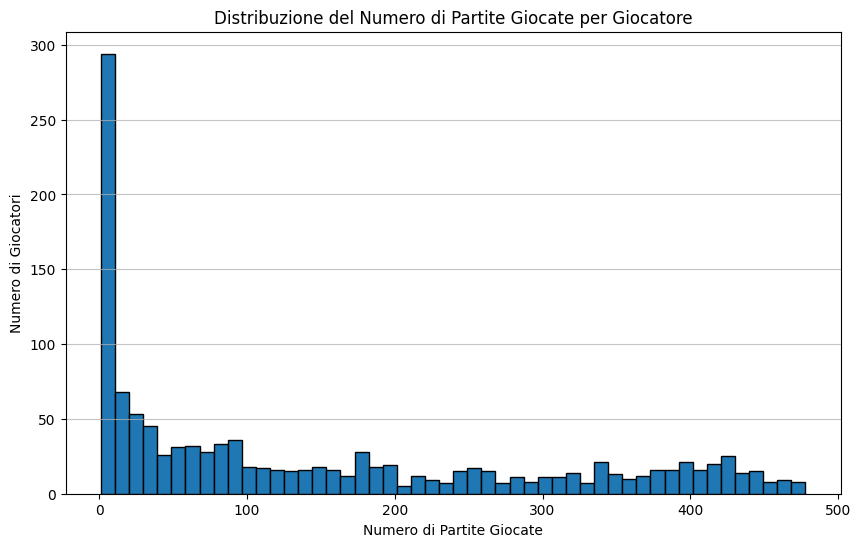


Top 5 Giocatori per Numero di Partite Giocate:
 playerId        playerName  gamesPlayed
   201980       Danny Green          478
     2617     Udonis Haslem          475
   202335 Patrick Patterson          474
   200782       P.J. Tucker          474
     2544      LeBron James          472

--- 2. Grado dei nodi :Team (numero di partite distinte giocate)

Statistiche Descrittive (Partite Distinte per Squadra):
count     30.000000
mean     454.800000
std       23.772485
min      419.000000
25%      435.250000
50%      455.000000
75%      467.000000
max      505.000000


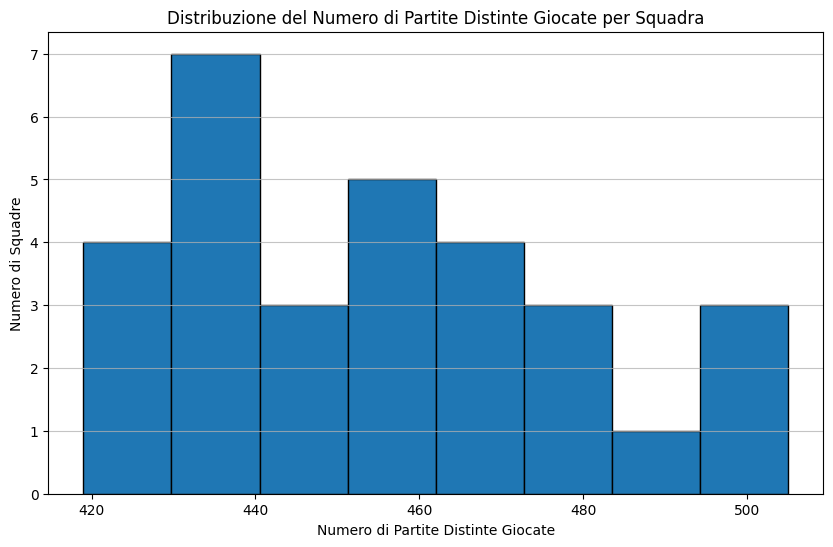


Squadre ordinate per Numero di Partite Distinte Giocate (Top 5):
    teamId  teamName  distinctGamesInvolved
1610612744  Warriors                    505
1610612761   Raptors                    504
1610612738   Celtics                    496
1610612745   Rockets                    486
1610612739 Cavaliers                    479

--- 3. Grado dei Nodi :Game (connessioni totali) ---

Statistiche Descrittive (Connessioni Totali per Partita):
count    6822.000000
mean       28.001612
std         2.870590
min        23.000000
25%        27.000000
50%        28.000000
75%        28.000000
max        42.000000


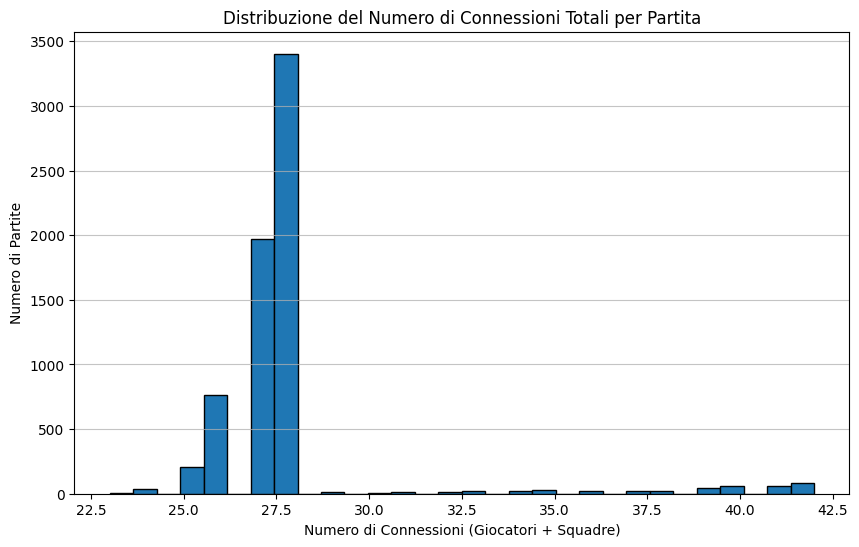


Top 5 Partite per Numero di Connessioni:
  gameId  totalConnections
11900079                42
11900069                42
11900065                42
11900068                42
11900059                42


In [ ]:
print(f"--- Analisi della Distribuzione dei Gradi nel database: '{db_name}' ---")
try:
    with driver.session(database=db_name) as session:
        # --- Grado dei Nodi :Player (partite giocate) ---
        print("\n--- 1. Grado dei Nodi :Player (numero di partite giocate) ---")
        player_degree_query = """
        MATCH (p:Player)-[r:PLAYED_IN_GAME]->(g:Game)
        RETURN p.playerId AS playerId, p.name AS playerName, count(g) AS gamesPlayed
        ORDER BY gamesPlayed DESC
        """
        results_players = session.run(player_degree_query)
        player_degrees = [{"playerId": r["playerId"], "playerName": r["playerName"], "gamesPlayed": r["gamesPlayed"]} for r in results_players]
        
        if player_degrees:
            df_player_degrees = pd.DataFrame(player_degrees)
            print("\nStatistiche Descrittive (Partite Giocate per Giocatore):")
            print(df_player_degrees['gamesPlayed'].describe().to_string())
            
            # Istogramma
            plt.figure(figsize=(10, 6))
            plt.hist(df_player_degrees['gamesPlayed'], bins=50, edgecolor='black')
            plt.title('Distribuzione del Numero di Partite Giocate per Giocatore')
            plt.xlabel('Numero di Partite Giocate')
            plt.ylabel('Numero di Giocatori')
            plt.grid(axis='y', alpha=0.75)
            plt.show()
            
            print("\nTop 5 Giocatori per Numero di Partite Giocate:")
            print(df_player_degrees.head(5).to_string(index=False))
        else:
            print("Nessun dato trovato per il grado dei giocatori.")

        print("\n--- 2. Grado dei nodi :Team (numero di partite distinte giocate)")
        team_degree_query = """
        MATCH (t:Team)-[:HOSTED_GAME | VISITED_GAME]->(g:Game)
        return t.teamId as teamId, t.nickname as teamName, count(distinct g) as distinctGamesInvolved
        order by distinctGamesInvolved DESC
        """
        results_teams = session.run(team_degree_query)
        team_degrees = [{"teamId": r["teamId"], "teamName": r["teamName"], "distinctGamesInvolved": r["distinctGamesInvolved"]} for r in results_teams]
   
        if team_degrees:
            df_team_degrees = pd.DataFrame(team_degrees)
            print("\nStatistiche Descrittive (Partite Distinte per Squadra):")
            print(df_team_degrees['distinctGamesInvolved'].describe().to_string())

            plt.figure(figsize=(10, 6))
            max_games = df_team_degrees['distinctGamesInvolved'].max()
            min_games = df_team_degrees['distinctGamesInvolved'].min()
            bin_width = 10
            if max_games is not None and min_games is not None and max_games > min_games :
                 bins_calculated = int((max_games - min_games) / bin_width) if int((max_games - min_games) / bin_width) > 0 else 10
            else:
                 bins_calculated = 10 # Fallback
            plt.hist(df_team_degrees['distinctGamesInvolved'], bins=bins_calculated, edgecolor='black')
            plt.title('Distribuzione del Numero di Partite Distinte Giocate per Squadra')
            plt.xlabel('Numero di Partite Distinte Giocate')
            plt.ylabel('Numero di Squadre')
            plt.grid(axis='y', alpha=0.75)
            plt.show()
    
            print("\nSquadre ordinate per Numero di Partite Distinte Giocate (Top 5):")
            print(df_team_degrees.head(5).to_string(index=False))
        else:
            print("Nessun dato trovato per il grando delle squadre")


        # --- Grado dei Nodi :Game (numero di giocatori + squadre connesse) ---
        print("\n--- 3. Grado dei Nodi :Game (connessioni totali) ---")
        # Il grado di un nodo Game è il numero di giocatori che vi hanno partecipato 
        # più le 2 squadre (casa e ospite).
        game_degree_query = """
        MATCH (g:Game)
        OPTIONAL MATCH (p:Player)-[:PLAYED_IN_GAME]->(g)
        OPTIONAL MATCH (t:Team)-[:HOSTED_GAME|VISITED_GAME]->(g) // Relazioni con le squadre
        RETURN g.gameId AS gameId, count(DISTINCT p) + count(DISTINCT t) AS totalConnections
        ORDER BY totalConnections DESC
        """
        results_games = session.run(game_degree_query)
        game_degrees = [{"gameId": r["gameId"], "totalConnections": r["totalConnections"]} for r in results_games]
        
        if game_degrees:
            df_game_degrees = pd.DataFrame(game_degrees)
            print("\nStatistiche Descrittive (Connessioni Totali per Partita):")
            print(df_game_degrees['totalConnections'].describe().to_string())

            plt.figure(figsize=(10, 6))
            plt.hist(df_game_degrees['totalConnections'], bins=30, edgecolor='black')
            plt.title('Distribuzione del Numero di Connessioni Totali per Partita')
            plt.xlabel('Numero di Connessioni (Giocatori + Squadre)')
            plt.ylabel('Numero di Partite')
            plt.grid(axis='y', alpha=0.75)
            plt.show()

            print("\nTop 5 Partite per Numero di Connessioni:")
            print(df_game_degrees.head(5).to_string(index=False))
        else:
            print("Nessun dato trovato per il grado delle partite.")
except Exception as e:
    print(f"Si è verificato un errore durante l'analisi della distribuzione dei gradi: {e}")


##### Interpretazione dei Risultati dell'Analisi dei Gradi
L'analisi della distribuzione dei gradi fornisce informazioni quantitative sulla connettività dei diversi tipi di nodi nel database Neo4j 'nba'. Di seguito sono riportate le osservazioni chiave per ciascuna entità analizzata:

**1. Grado dei Nodi `:Player` (Numero di Partite Giocate)**
*   **Statistiche Generali**: L'analisi ha coinvolto 1212 giocatori. In media, un giocatore ha partecipato a circa 146 partite, con una deviazione standard notevole (circa 150 partite), indicando una grande variabilità nel numero di partite giocate tra i giocatori. Il range va da un minimo di 1 partita a un massimo di 478 partite.
*   **Distribuzione**: La distribuzione è asimmetrica a destra, come suggerito dalla media (146) che è significativamente più alta della mediana (85 partite). Questo significa che la maggior parte dei giocatori ha disputato un numero relativamente basso di partite, mentre un numero minore di giocatori (i "veterani" o "super-star") ha accumulato un numero molto elevato di presenze.
*   **Giocatori con Più Presenze**: Giocatori come Danny Green (478 partite), Udonis Haslem (475 partite) e Patrick Patterson (474 partite) figurano tra quelli con il maggior numero di partite giocate nel periodo considerato, evidenziando la loro longevità e costanza.

**2. Grado dei Nodi `:Team` (Numero di Partite Distinte Giocate)**
*   **Statistiche Generali**: Sono state analizzate 30 squadre. In media, una squadra è stata coinvolta in circa 455 partite distinte, con una deviazione standard relativamente bassa (circa 24 partite). Questo suggerisce una partecipazione abbastanza uniforme delle squadre al campionato nel periodo analizzato. Il numero di partite varia da 419 a 505.
*   **Distribuzione**: La distribuzione del numero di partite per squadra è più concentrata attorno alla media, indicando che la maggior parte delle squadre ha giocato un numero simile di partite.
*   **Squadre con Più Partite**: Squadre come i Warriors (505 partite), Raptors (504 partite) e Celtics (496 partite) mostrano il maggior numero di partite giocate, il che è indice di lunghe partecipazioni ai playoff.

**3. Grado dei Nodi `:Game` (Connessioni Totali)**
*   **Statistiche Generali**: L'analisi ha coperto 6822 partite. In media, una partita ha circa 28 connessioni totali (giocatori partecipanti + le due squadre coinvolte). La deviazione standard è molto bassa (circa 2.87), indicando che la maggior parte delle partite ha un numero simile di entità connesse.
*   **Distribuzione**: La distribuzione è fortemente concentrata attorno alla media (28 connessioni), con il 50% delle partite (tra il 25° e il 75° percentile) che ha tra 27 e 28 connessioni. Questo suggerisce una struttura di partecipazione alle partite molto regolare.
    *   Il numero medio di circa 28 connessioni è coerente con la struttura tipica di una partita NBA: 2 squadre + circa 13 giocatori attivi per squadra (2 + 13*2 = 28).
*   **Variazioni**:
    *   Valori minimi (es. 23 connessioni) possono indicare partite con un numero ridotto di giocatori a referto o utilizzati.
    *   Valori massimi (es. 42 connessioni) sono atipici e potrebbero rappresentare partite con un turnover di giocatori più elevato del solito (ad esempio, partite di pre-stagione, fine stagione con roster allargati, o situazioni particolari come numerosi infortuni che portano a utilizzare più giocatori dalla panchina o ingaggiati per brevi periodi).



### Analisi margine vittoria: blowouts e partite combattute con dettaglio partite 


--- Analisi del Margine di Vittoria nel database: 'nba' ---

--- Partite con il Maggior Scarto (Top 5 Blowouts) ---
  gameDate homeTeamName visitorTeamName  pointsHome  pointsAway  marginOfVictory
2018-03-22      Hornets       Grizzlies       140.0        79.0             61.0
2018-12-08        Bulls         Celtics        77.0       133.0             56.0
2015-12-07        76ers           Spurs        68.0       119.0             51.0
2018-11-14    Mavericks            Jazz       118.0        68.0             50.0
2015-11-02     Warriors       Grizzlies       119.0        69.0             50.0

--- Partite Più Combattute (Margine <= 1 punto) ---
Numero totale di partite con margine <= 1 punto: 267

Esempi di Partite Molto Combattute (prime 5 per data):
  gameDate homeTeamName visitorTeamName  pointsHome  pointsAway  marginOfVictory
2015-10-08        76ers       Cavaliers       115.0       114.0              1.0
2015-10-18         Nets           76ers        92.0        91.0           

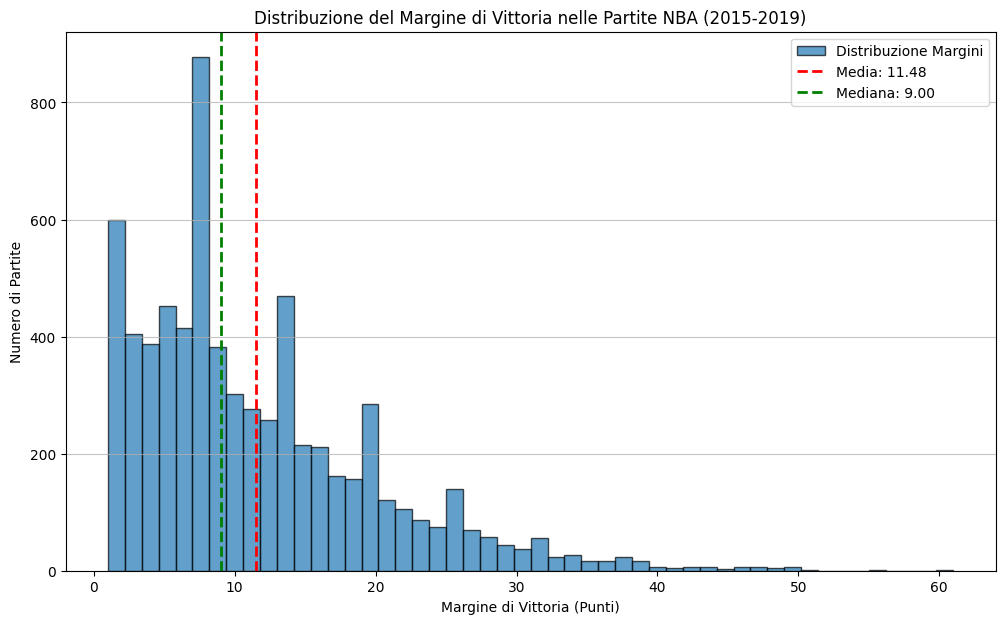

In [50]:
print(f"--- Analisi del Margine di Vittoria nel database: '{db_name}' ---")

try:
    with driver.session(database=db_name) as session:

        # --- Calcolo del Margine di Vittoria per tutte le partite ---
        margin_query = """
        MATCH (g:Game)
        OPTIONAL MATCH (homeTeam:Team)-[:HOSTED_GAME]->(g)
        OPTIONAL MATCH (visitorTeam:Team)-[:VISITED_GAME]->(g)
        RETURN g.gameId AS gameId, 
               g.date AS gameDate, 
               homeTeam.nickname AS homeTeamName, 
               visitorTeam.nickname AS visitorTeamName,
               g.ptsHome AS pointsHome, 
               g.ptsAway AS pointsAway, 
               abs(g.ptsHome - g.ptsAway) AS marginOfVictory
        """
        results_margins = session.run(margin_query)
        all_games_margins = [dict(record) for record in results_margins] # Converte in lista di dizionari
        
        if not all_games_margins:
            print("Nessun dato sulle partite trovato per calcolare i margini di vittoria.")
        else:
            df_margins = pd.DataFrame(all_games_margins)

            # --- Partite con il Maggior Scarto (Blowout) ---
            print("\n--- Partite con il Maggior Scarto (Top 5 Blowouts) ---")
            df_blowouts = df_margins.sort_values(by='marginOfVictory', ascending=False).head(5)
            print(df_blowouts[['gameDate', 'homeTeamName', 'visitorTeamName', 'pointsHome', 'pointsAway', 'marginOfVictory']].to_string(index=False))

            # --- Partite Più Combattute (Margine <= 1 punto) ---
            print("\n--- Partite Più Combattute (Margine <= 1 punto) ---")
            df_close_games = df_margins[df_margins['marginOfVictory'] <= 1].sort_values(by='gameDate')
            print(f"Numero totale di partite con margine <= 1 punto: {len(df_close_games)}")
            if not df_close_games.empty:
                print("\nEsempi di Partite Molto Combattute (prime 5 per data):")
                print(df_close_games[['gameDate', 'homeTeamName', 'visitorTeamName', 'pointsHome', 'pointsAway', 'marginOfVictory']].head(5).to_string(index=False))
            
            # ---  Margine di Vittoria Medio e Confronto Grafico ---
            if not df_margins.empty and 'marginOfVictory' in df_margins.columns:
                mean_margin = df_margins['marginOfVictory'].mean()
                median_margin = df_margins['marginOfVictory'].median()
                
                print(f"\n--- Statistiche del Margine di Vittoria (2015-2019) ---")
                print(f"Margine di Vittoria Medio: {mean_margin:.2f} punti")
                print(f"Margine di Vittoria Mediano: {median_margin:.2f} punti")
                print(df_margins['marginOfVictory'].describe().to_string())

                # Grafico: Istogramma della distribuzione del margine di vittoria con media e mediana
                plt.figure(figsize=(12, 7))
                plt.hist(df_margins['marginOfVictory'], bins=50, edgecolor='black', alpha=0.7, label='Distribuzione Margini')
                plt.axvline(mean_margin, color='red', linestyle='dashed', linewidth=2, label=f'Media: {mean_margin:.2f}')
                plt.axvline(median_margin, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {median_margin:.2f}')
                plt.title('Distribuzione del Margine di Vittoria nelle Partite NBA (2015-2019)')
                plt.xlabel('Margine di Vittoria (Punti)')
                plt.ylabel('Numero di Partite')
                plt.legend()
                plt.grid(axis='y', alpha=0.75)
                plt.show()
            else:
                print("Impossibile calcolare le statistiche del margine di vittoria (DataFrame vuoto o colonna mancante).")

except Exception as e:
    print(f"Si è verificato un errore durante l'analisi del margine di vittoria: {e}")


In [42]:
print(f"--- Analisi Squadra con Più Vittorie per Stagione ---")

try:
    with driver.session(database=db_name) as session:
        
        top_team_per_season_query = """
        MATCH (g:Game)
        WHERE g.season IS NOT NULL AND g.homeTeamWins IS NOT NULL

        CALL {
            WITH g 
            OPTIONAL MATCH (ht_node:Team)-[:HOSTED_GAME]->(g)
            RETURN ht_node
            LIMIT 1 
        }
        CALL {
            WITH g
            OPTIONAL MATCH (vt_node:Team)-[:VISITED_GAME]->(g)
            RETURN vt_node
            LIMIT 1
        }
        WITH g, ht_node AS homeTeam, vt_node AS visitorTeam
        WHERE homeTeam IS NOT NULL AND visitorTeam IS NOT NULL AND 
              homeTeam.nickname IS NOT NULL AND visitorTeam.nickname IS NOT NULL AND
              homeTeam.teamId IS NOT NULL AND visitorTeam.teamId IS NOT NULL

        WITH g.season AS season,
             CASE g.homeTeamWins
                 WHEN true THEN homeTeam
                 ELSE visitorTeam
             END AS winningTeamNode,
             CASE g.homeTeamWins
                 WHEN true THEN visitorTeam
                 ELSE homeTeam
             END AS losingTeamNode

        // Crea una riga per ogni squadra coinvolta (vincitore e perdente)
        UNWIND [
            {team: winningTeamNode, status: 'win'},
            {team: losingTeamNode,  status: 'loss'}
        ] AS game_outcome

        // Aggrega vittorie e sconfitte per squadra per stagione
        WITH season, game_outcome.team AS teamNode,
             SUM(CASE game_outcome.status WHEN 'win' THEN 1 ELSE 0 END) AS wins,
             SUM(CASE game_outcome.status WHEN 'loss' THEN 1 ELSE 0 END) AS losses
        
        // Ordina per stagione e poi per vittorie (decrescente) per trovare la squadra top
        ORDER BY season ASC, wins DESC

        // Raccoglie tutte le statistiche delle squadre per ogni stagione
        WITH season, collect({
            teamName: teamNode.nickname,
            teamId: teamNode.teamId,
            wins: wins,
            losses: losses
        }) AS teamsSeasonalStats
        
        // Assicura che ci siano dati per la stagione prima di tentare di accedere all'indice [0]
        WHERE size(teamsSeasonalStats) > 0 

        // Restituisce la squadra con più vittorie (la prima nella lista raccolta) per ogni stagione
        RETURN season,
               teamsSeasonalStats[0].teamName AS topTeamName,
               teamsSeasonalStats[0].wins AS topTeamWins,
               teamsSeasonalStats[0].losses AS topTeamLosses
        ORDER BY season ASC
        """
        
        results = session.run(top_team_per_season_query)
        top_teams_data = [dict(record) for record in results]
        
        if not top_teams_data:
            print("Nessun dato trovato per l'analisi delle squadre con più vittorie per stagione.")
        else:
            df_top_teams = pd.DataFrame(top_teams_data)
            
            print("\n--- Squadra con Più Vittorie per Stagione ---")
            if not df_top_teams.empty:
                df_top_teams.rename(columns={
                    'season': 'Stagione',
                    'topTeamName': 'Squadra con Più Vittorie',
                    'topTeamWins': 'Vittorie',
                    'topTeamLosses': 'Sconfitte'
                }, inplace=True)
                print(df_top_teams.to_string(index=False))
            else:
                print("Non è stato possibile determinare la squadra con più vittorie per nessuna stagione.")

except Exception as e:
    print(f"Si è verificato un errore durante l'analisi delle squadre con più vittorie per stagione: {e}")

--- Analisi Squadra con Più Vittorie per Stagione ---

--- Squadra con Più Vittorie per Stagione ---
 Stagione Squadra con Più Vittorie  Vittorie  Sconfitte
     2015                 Warriors        91         22
     2016                 Warriors        89         17
     2017                  Rockets        79         24
     2018                  Raptors        77         33
     2019                   Lakers        73         28


---

<br> <br>


## Valutazione della Centralità dei Giocatori Basata sulla Co-partecipazione alle Partite

*Come possiamo quantificare l'importanza o la "centralità" di un giocatore all'interno della rete di tutte le partite giocate, basandoci su con chi hanno condiviso il campo? Se costruiamo un grafo dove i giocatori sono nodi e una relazione esiste tra due giocatori se hanno partecipato alla stessa partita (pesata dal numero di partite giocate insieme), quali giocatori emergono come i più centrali? L'ipotesi è che i giocatori che partecipano a più partite, e lo fanno insieme ad altri giocatori frequentemente coinvolti, avranno una maggiore centralità.*


**Definizione del Grafo di Co-partecipazione:**  
*   **Nodi:** Saranno i singoli giocatori (`:Player`).
*   **Relazioni:** Tra coppie di giocatori. Una relazione `(PlayerA)-[:PLAYED_WITH_OR_AGAINST]->(PlayerB)` sarebbe esistita se `PlayerA` e `PlayerB` avessero partecipato entrambi alla stessa partita.
*   **Peso della Relazione:** La relazione sarebbe stata pesata (`weight`) dal numero di partite distinte a cui entrambi i giocatori avevano partecipato congiuntamente. Questo avrebbe dato più forza ai legami tra giocatori che avevano condiviso il campo più frequentemente.


Questa analisi mira a una comprensione della struttura della rete dei giocatori basata sulla loro presenza condivisa nelle partite, usando la DegreeCentrality e PageRank

In [24]:
# Nome della proiezione del grafo
graph_name = 'player_interactions_graph'

# Query per creare la proiezione del grafo
# Nodi: Player
# Relazioni: SHARED_GAME tra giocatori che hanno partecipato alla stessa partita.
# La relazione sarà pesata dal numero di partite condivise.

# Controllo esistenza grafo e conseguente cancellazione - per evitare conflitti
try:
    print(f"Verifica esistenza e cancellazione del grafo '{graph_name}' se presente...")
    with driver.session(database=db_name) as session:
        session.run(f"""
            CALL gds.graph.drop('{graph_name}', false)
            YIELD graphName
            RETURN 'Grafo ' + graphName + ' cancellato (se esisteva).' AS result
        """)
    print(f"Eventuale grafo '{graph_name}' preesistente cancellato o non trovato.")
except Exception as e:
    print(f"Un errore è occorso durante il tentativo di cancellare il grafo (potrebbe essere normale se non esisteva o per altre ragioni): {e}")


print(f"\nCreazione della proiezione del grafo '{graph_name}'...")
try:
    with driver.session(database=db_name) as session:
        result = session.run(f"""
            CALL gds.graph.project.cypher(
                '{graph_name}',
                'MATCH (p:Player) RETURN id(p) AS id, labels(p) AS labels',
                'MATCH (p1:Player)-[:PLAYED_IN_GAME]->(g:Game)<-[:PLAYED_IN_GAME]-(p2:Player) 
                 WHERE id(p1) < id(p2) 
                 RETURN id(p1) AS source, id(p2) AS target, "SHARED_GAME" AS type, count(g) AS weight'
            )
            YIELD
                graphName, nodeCount, relationshipCount, projectMillis
            RETURN
                graphName, nodeCount, relationshipCount, projectMillis
        """)
        projection_stats = result.single()
        if projection_stats:
            print(f"Proiezione del grafo '{projection_stats['graphName']}' creata con successo.")
            print(f"Nodi proiettati: {projection_stats['nodeCount']}")
            print(f"Relazioni proiettate: {projection_stats['relationshipCount']}")
            print(f"Tempo di proiezione: {projection_stats['projectMillis']} ms")
            
            # Elenco schema del named graph creato 
            print(f"\nVerifica dello schema del grafo '{graph_name}' in GDS...")
            schema_result = session.run(f"CALL gds.graph.list('{graph_name}') YIELD graphName, schema RETURN graphName, schema").single()
            if schema_result and schema_result['schema']:
                print(f"Schema per '{schema_result['graphName']}':")
                print(f"  Nodi: {schema_result['schema']['nodes']}") 
                print(f"  Relazioni: {schema_result['schema']['relationships']}")
            else:
                print("Impossibile recuperare lo schema del grafo da GDS per la verifica.")
        else:
            print("Errore: la proiezione del grafo non ha restituito statistiche.")

except Exception as e:
    print(f"Si è verificato un errore durante la creazione della proiezione del grafo: {e}")


Verifica esistenza e cancellazione del grafo 'player_interactions_graph' se presente...
Eventuale grafo 'player_interactions_graph' preesistente cancellato o non trovato.

Creazione della proiezione del grafo 'player_interactions_graph'...
Proiezione del grafo 'player_interactions_graph' creata con successo.
Nodi proiettati: 1769
Relazioni proiettate: 284949
Tempo di proiezione: 1386 ms

Verifica dello schema del grafo 'player_interactions_graph' in GDS...
Schema per 'player_interactions_graph':
  Nodi: {'Player': {}}
  Relazioni: {'SHARED_GAME': {'weight': 'Float (DefaultValue(NaN), TRANSIENT, Aggregation.NONE)'}}


Inizio analisi GDS sul grafo: player_interactions_graph

--- Esecuzione Degree Centrality (Pesata) ---
Top 10 Giocatori per Degree Centrality (Pesata):
  Giocatore: Al Horford, Grado Pesato: 11156.0
  Giocatore: Tobias Harris, Grado Pesato: 10973.0
  Giocatore: Bojan Bogdanovic, Grado Pesato: 10734.0
  Giocatore: Giannis Antetokounmpo, Grado Pesato: 10441.0
  Giocatore: Joe Ingles, Grado Pesato: 10366.0
  Giocatore: Cory Joseph, Grado Pesato: 10277.0
  Giocatore: Jeff Green, Grado Pesato: 10243.0
  Giocatore: Rudy Gobert, Grado Pesato: 10237.0
  Giocatore: Julius Randle, Grado Pesato: 10234.0
  Giocatore: Pat Connaughton, Grado Pesato: 10178.0

--- Esecuzione PageRank (con pesi) ---
Top 10 Giocatori per PageRank:
  Giocatore: Edgar Sosa, PageRank Score: 9.1219
  Giocatore: Marshall Henderson, PageRank Score: 8.6614
  Giocatore: Chris Johnson, PageRank Score: 8.0751
  Giocatore: Jon Horford, PageRank Score: 7.0712
  Giocatore: Nick Minnerath, PageRank Score: 5.5702
  Giocatore: Quincy M

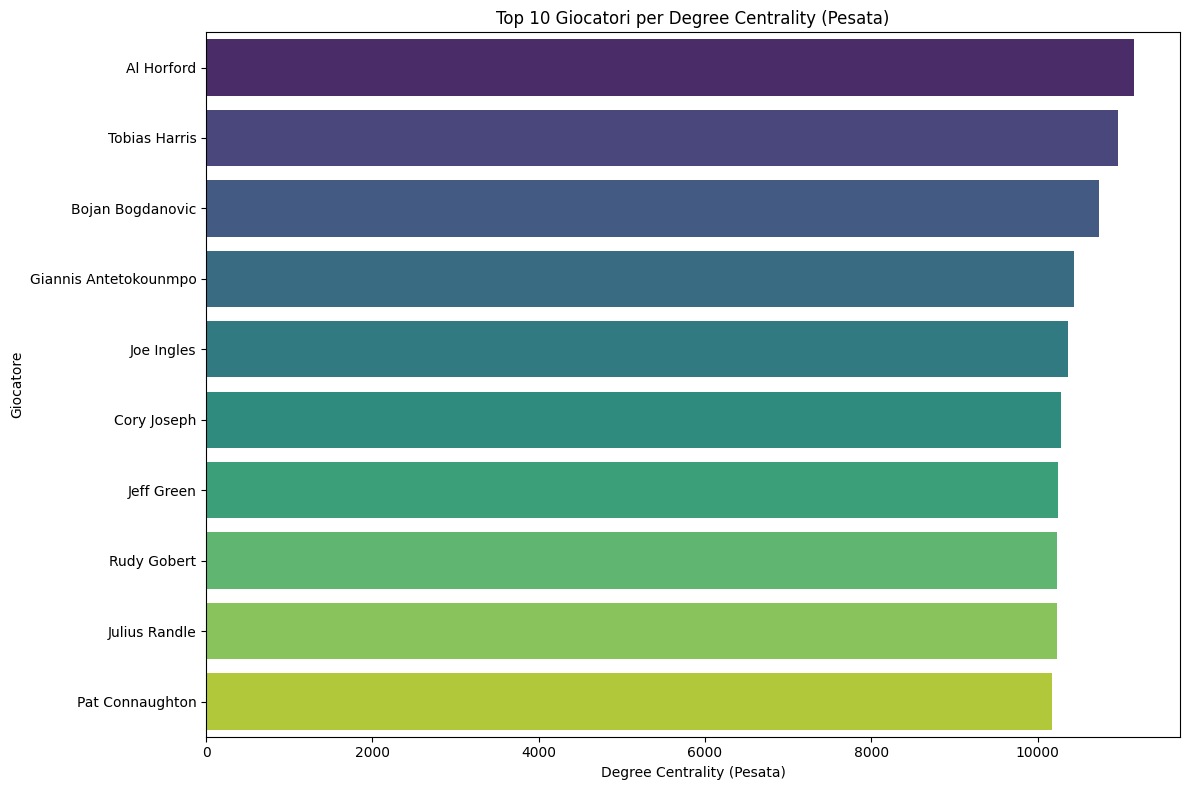

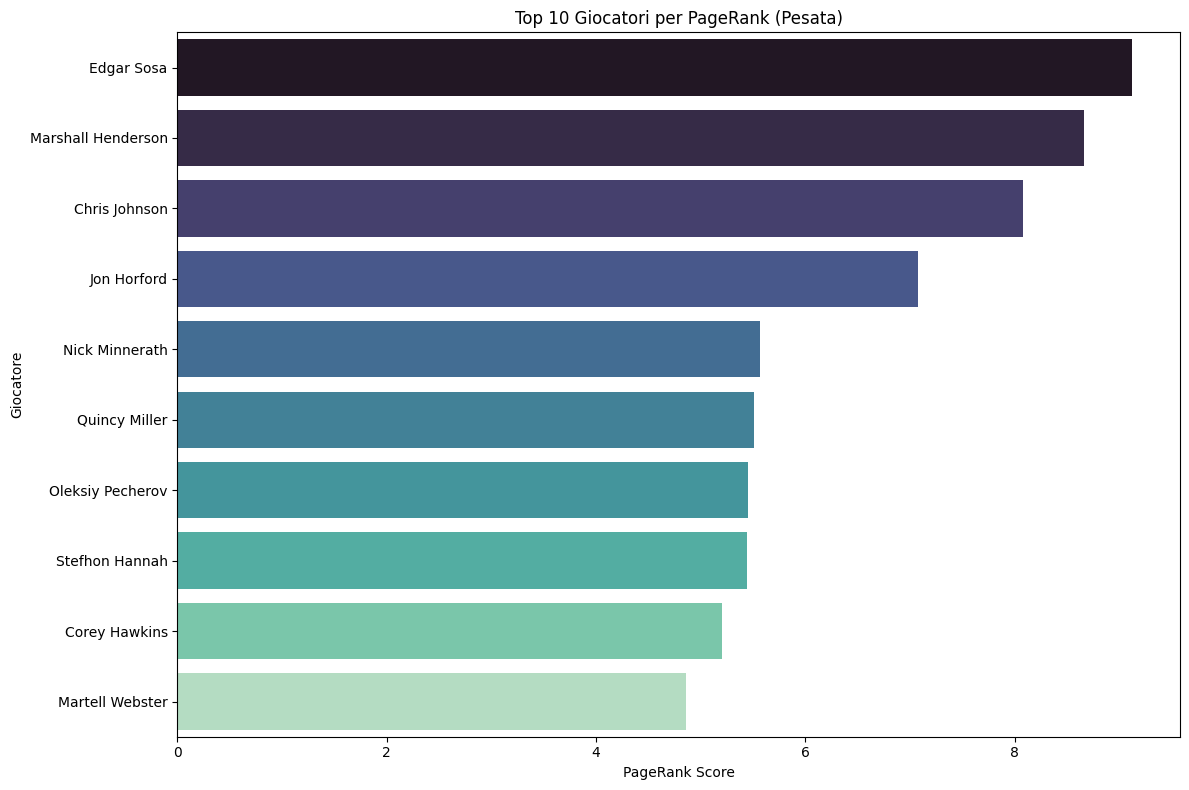

In [ ]:
graph_name = 'player_interactions_graph'

print(f"Inizio analisi GDS sul grafo: {graph_name}")

# --- Dati per i grafici ---
degree_players = []
degree_scores = []
pagerank_players = []
pagerank_scores = []

# 1. Degree Centrality (Pesata)
print("\n--- Esecuzione Degree Centrality (Pesata) ---")
try:
    with driver.session(database=db_name) as session:
        result_degree = session.run(f"""
            CALL gds.degree.stream('{graph_name}', {{
                relationshipWeightProperty: 'weight'
            }})
            YIELD nodeId, score
            WITH gds.util.asNode(nodeId) AS playerNode, score AS weightedDegree
            RETURN playerNode.name AS playerName, playerNode.playerId AS playerId, weightedDegree 
            ORDER BY weightedDegree DESC
            LIMIT 10
        """)
        print("Top 10 Giocatori per Degree Centrality (Pesata):")
        for record in result_degree:
            player_name = record['playerName'] if record['playerName'] else f"ID: {record['playerId']}"
            degree_players.append(player_name)
            degree_scores.append(record['weightedDegree'])
            print(f"  Giocatore: {player_name}, Grado Pesato: {record['weightedDegree']}")
except Exception as e:
    print(f"Errore durante l'esecuzione di Degree Centrality: {e}")

# 2. PageRank Pesata
print("\n--- Esecuzione PageRank (con pesi) ---")
try:
    with driver.session(database=db_name) as session:
        result_pagerank = session.run(f"""
            CALL gds.pageRank.stream('{graph_name}', {{
                relationshipWeightProperty: 'weight',
                maxIterations: 20,
                dampingFactor: 0.85
            }})
            YIELD nodeId, score
            WITH gds.util.asNode(nodeId) AS playerNode, score AS pageRankScore
            RETURN playerNode.name AS playerName, playerNode.playerId AS playerId, pageRankScore
            ORDER BY pageRankScore DESC
            LIMIT 10
        """)
        print("Top 10 Giocatori per PageRank:")
        for record in result_pagerank:
            player_name = record['playerName'] if record['playerName'] else f"ID: {record['playerId']}"
            pagerank_players.append(player_name)
            pagerank_scores.append(record['pageRankScore'])
            print(f"  Giocatore: {player_name}, PageRank Score: {record['pageRankScore']:.4f}")
except Exception as e:
    print(f"Errore durante l'esecuzione di PageRank: {e}")

# --- Visualizzazione dei Risultati ---
print("\n--- Creazione Grafici ---")

# Grafico per Degree Centrality
if degree_players and degree_scores:
    plt.figure(figsize=(12, 8))
    sns.barplot(x=degree_scores, y=degree_players, palette="viridis", hue=degree_players, legend=False)
    plt.title('Top 10 Giocatori per Degree Centrality (Pesata)')
    plt.xlabel('Degree Centrality (Pesata)')
    plt.ylabel('Giocatore')
    plt.tight_layout()
    plt.show()
else:
    print("Dati non sufficienti per generare il grafico Degree Centrality.")

# Grafico per PageRank
if pagerank_players and pagerank_scores:
    plt.figure(figsize=(12, 8))
    sns.barplot(x=pagerank_scores, y=pagerank_players, palette="mako", hue=pagerank_players, legend=False)
    plt.title('Top 10 Giocatori per PageRank (Pesata)')
    plt.xlabel('PageRank Score')
    plt.ylabel('Giocatore')
    plt.tight_layout()
    plt.show()
else:
    print("Dati non sufficienti per generare il grafico PageRank.")

Dopo aver proiettato il grafo `player_interactions_graph`, abbiamo calcolato due misure di centralità per identificare i giocatori più rilevanti all'interno di questa rete.

### Risultati della Degree Centrality (Pesata)

Il grafico "Top 10 Giocatori per Degree Centrality (Pesata)" mostra i giocatori che hanno accumulato il maggior "peso" di interazioni, ovvero coloro che hanno condiviso il campo nel maggior numero di partite con altri giocatori.

*   **Osservazioni Iniziali:** I giocatori che appaiono in cima a questa classifica (es. Al Horford, Tobias Harris, Bojan Bogdanovic, Giannis Antetokounmpo) sono atleti noti, con una presenza significativa e costante nelle stagioni NBA analizzate (2015-2019). Questo risultato è intuitivo: chi gioca di più e con più partner di gioco diversi (o più frequentemente con gli stessi) avrà un grado pesato più elevato. La Degree Centrality, in questo contesto, sembra riflettere una combinazione di longevità, partecipazione e il numero di compagni/avversari unici con cui si è interagito pesato dalla frequenza.

### Risultati di PageRank (Pesata) e Prime Ambivalenze

Il grafico "Top 10 Giocatori per PageRank (Pesata)" presenta un quadro inizialmente più sorprendente e meno intuitivo.

*   **Osservazioni Iniziali e Ambivalenze:** Contrariamente alla Degree Centrality, la classifica PageRank è dominata da giocatori come Edgar Sosa, Marshall Henderson e Chris Johnson. Molti di questi nomi non corrispondono ai giocatori "superstar" o più centrali nell'ecosistema NBA in termini di performance o fama consolidata. In particolare, emerge che alcuni di questi giocatori hanno un numero di partite giocate nel nostro dataset relativamente basso.
*   **Anomalia Principale:** La presenza di giocatori con poche presenze ai vertici del PageRank è un risultato anomalo. Ci si aspetterebbe che giocatori con una carriera più estesa e un maggior numero di interazioni complessive (come quelli visti nella Degree Centrality) dominassero anche questa metrica, che teoricamente dovrebbe premiare chi è connesso a nodi a loro volta importanti.

**Prossimi Passi Investigativi:**

Questi risultati inattesi del PageRank suggeriscono che la struttura della rete `player_interactions_graph` potrebbe avere caratteristiche particolari che influenzano l'algoritmo in modi non immediatamente ovvi. La discrepanza tra i risultati della Degree Centrality (più allineati con l'esperienza e la presenza in campo) e quelli del PageRank (che evidenzia figure meno note) necessita di un'analisi più approfondita.

Per comprendere meglio il perché di questi punteggi PageRank elevati per giocatori con track record limitato, nelle sezioni successive esploreremo ulteriormente la struttura di questa rete, in particolare attraverso l' **analisi delle comunità (Community Detection)**. L'ipotesi è che questi giocatori possano far parte di sotto-reti (comunità) molto dense o con particolari configurazioni che "gonfiano" localmente il loro punteggio PageRank, rendendoli figure centrali all'interno di nicchie specifiche piuttosto che nell'intera rete globale.


--- Analisi Connessioni per il Giocatore: Stephen Curry ---
Trovato Node ID per Stephen Curry: 492

Top 10 giocatori con cui Stephen Curry ha condiviso più partite (basato su :PLAYED_IN_GAME):
  Klay Thompson (ID: 202691), Partite Condivise: 378
  Draymond Green (ID: 203110), Partite Condivise: 376
  Shaun Livingston (ID: 2733), Partite Condivise: 353
  Andre Iguodala (ID: 2738), Partite Condivise: 329
  Kevon Looney (ID: 1626172), Partite Condivise: 264
  Kevin Durant (ID: 201142), Partite Condivise: 238
  Ian Clark (ID: 203546), Partite Condivise: 216
  JaVale McGee (ID: 201580), Partite Condivise: 187
  Zaza Pachulia (ID: 2585), Partite Condivise: 166
  David West (ID: 2561), Partite Condivise: 160


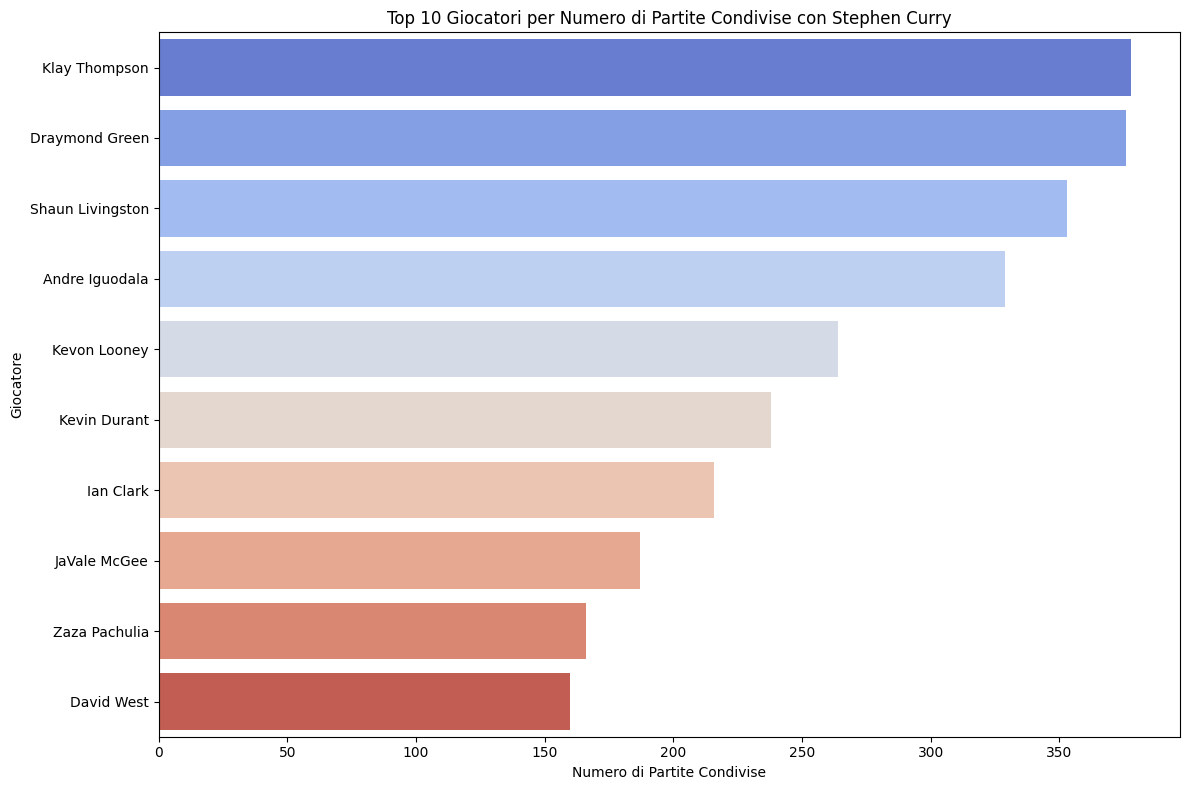

Grafico connessioni per Stephen Curry generato.


In [ ]:
# Giocatore da investigare (può essere cambiato)
target_player_name = "Stephen Curry" 
print(f"\n--- Analisi Connessioni per il Giocatore: {target_player_name} ---")

# Dati per il grafico
connected_players = []
shared_games_counts = []

try:
    with driver.session(database=db_name) as session:
        # Prima troviamo il nodeId del giocatore target.
        # Usiamo 'name' come da schema.md.
        find_player_query = f"""
            MATCH (p:Player {{name: '{target_player_name}'}})
            RETURN id(p) AS nodeId
            LIMIT 1
        """
        player_id_result = session.run(find_player_query).single()

        if player_id_result:
            target_node_id = player_id_result['nodeId']
            print(f"Trovato Node ID per {target_player_name}: {target_node_id}")

            # Ora troviamo con chi ha condiviso più partite nel grafo proiettato
            # Questa query opera sul grafo GDS in memoria.
            # Nota: la relazione SHARED_GAME è stata creata con id(p1) < id(p2),
            # quindi dobbiamo cercare il target_node_id sia come source che come target.
            
            query_connections = f"""
            MATCH (targetPlayer:Player {{name: '{target_player_name}'}})
            MATCH (targetPlayer)-[:PLAYED_IN_GAME]->(g:Game)<-[:PLAYED_IN_GAME]-(otherPlayer:Player)
            WHERE targetPlayer <> otherPlayer
            WITH otherPlayer, count(DISTINCT g) AS gamesPlayedTogether
            RETURN otherPlayer.name AS collaboratorName, otherPlayer.playerId AS collaboratorId, gamesPlayedTogether
            ORDER BY gamesPlayedTogether DESC
            LIMIT 10
            """

            result_connections = session.run(query_connections)
            
            print(f"\nTop 10 giocatori con cui {target_player_name} ha condiviso più partite (basato su :PLAYED_IN_GAME):")
            count = 0
            for record in result_connections:
                count += 1
                collaborator_name = record['collaboratorName']
                games_shared = record['gamesPlayedTogether']
                connected_players.append(collaborator_name)
                shared_games_counts.append(games_shared)
                print(f"  {collaborator_name} (ID: {record['collaboratorId']}), Partite Condivise: {games_shared}")
            
            if count == 0:
                print(f"Nessuna interazione trovata per {target_player_name} con la query attuale (controlla nome/ID e dati).")
        else:
            print(f"Giocatore '{target_player_name}' non trovato nel database.")
except Exception as e:
    print(f"Errore durante l'analisi delle connessioni del giocatore: {e}")

# --- Visualizzazione Grafico Connessioni ---
if connected_players and shared_games_counts:
    plt.figure(figsize=(12, 8))
    sns.barplot(x=shared_games_counts, y=connected_players, palette="coolwarm", hue=connected_players, legend=False)
    plt.title(f'Top 10 Giocatori per Numero di Partite Condivise con {target_player_name}')
    plt.xlabel('Numero di Partite Condivise')
    plt.ylabel('Giocatore')
    plt.tight_layout()
    plt.show()
else:
    print(f"Dati non sufficienti per generare il grafico delle connessioni per {target_player_name}.")


Abbiamo analizzato un giocatore considerato "super-star" e notiamo che ha condiviso molte partite con altri giocatori Cambiando il parametro con "Edgar Sosa" che è al vertice del pagerank noteremo che tale giocatore ha un massimo di 2 partite giocate.  

Proviamo a fare un page rank non pesato per vedere se i risultati cambiano


--- Esecuzione PageRank (NON Pesata) ---
Top 10 Giocatori per PageRank (NON Pesata):
  Giocatore: Edgar Sosa, PageRank Score: 10.0141
  Giocatore: Marshall Henderson, PageRank Score: 9.5902
  Giocatore: Jon Horford, PageRank Score: 8.3216
  Giocatore: Chris Johnson, PageRank Score: 6.4274
  Giocatore: Oleksiy Pecherov, PageRank Score: 6.3885
  Giocatore: Martell Webster, PageRank Score: 5.7444
  Giocatore: Corey Hawkins, PageRank Score: 5.5722
  Giocatore: Stefhon Hannah, PageRank Score: 5.2564
  Giocatore: Tony Mitchell, PageRank Score: 4.9648
  Giocatore: Nick Minnerath, PageRank Score: 4.9465


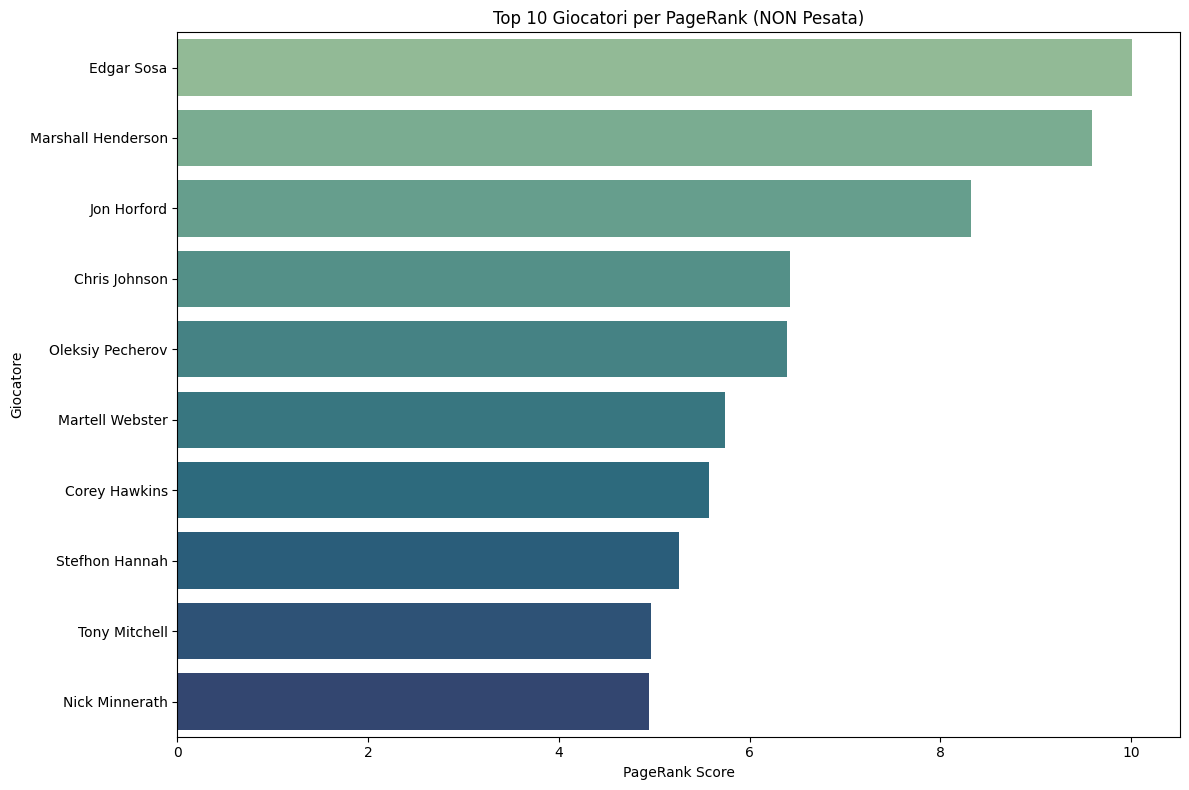

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Dati per i grafici ---
pagerank_unweighted_players = []
pagerank_unweighted_scores = []

# PageRank (NON Pesata)
# Eseguiamo PageRank senza considerare i pesi delle relazioni ('weight')
# per vedere come cambia la classifica.
print("\n--- Esecuzione PageRank (NON Pesata) ---")
try:
    with driver.session(database=db_name) as session:
        result_pagerank_unweighted = session.run(f"""
            CALL gds.pageRank.stream('{graph_name}', {{
                // NESSUNA relationshipWeightProperty specificata questa volta
                maxIterations: 20,
                dampingFactor: 0.85
            }})
            YIELD nodeId, score
            WITH gds.util.asNode(nodeId) AS playerNode, score AS pageRankScore
            RETURN playerNode.name AS playerName, playerNode.playerId AS playerId, pageRankScore
            ORDER BY pageRankScore DESC
            LIMIT 10 
        """)
        print("Top 10 Giocatori per PageRank (NON Pesata):")
        for record in result_pagerank_unweighted:
            player_name = record['playerName'] if record['playerName'] else f"ID: {record['playerId']}"
            pagerank_unweighted_players.append(player_name)
            pagerank_unweighted_scores.append(record['pageRankScore'])
            print(f"  Giocatore: {player_name}, PageRank Score: {record['pageRankScore']:.4f}")
except Exception as e:
    print(f"Errore durante l'esecuzione di PageRank (NON Pesata): {e}")

# --- Visualizzazione Grafico PageRank (NON Pesata) ---
if pagerank_unweighted_players and pagerank_unweighted_scores:
    plt.figure(figsize=(12, 8))
    sns.barplot(x=pagerank_unweighted_scores, y=pagerank_unweighted_players, palette="crest", hue=pagerank_unweighted_players, legend=False) # Changed palette
    plt.title('Top 10 Giocatori per PageRank (NON Pesata)')
    plt.xlabel('PageRank Score')
    plt.ylabel('Giocatore')
    plt.tight_layout()
    plt.show()
else:
    print("Dati non sufficienti per generare il grafico PageRank (NON Pesata).")

I risultati sono ambigui anche privando PageRank dei pesi

In [ ]:
print(f"Ulteriori indagini su PageRank e Community Detection sul grafo: {graph_name}")

# Verifica del Numero Totale di Partite Giocate da un Giocatore Specifico
# ------------------------------------------------------------------------
target_player_for_game_count = "Edgar Sosa" # Puoi cambiarlo se vuoi
try:
    with driver.session(database=db_name) as session:
        game_count_result = session.run(f"""
            MATCH (p:Player {{name: '{target_player_for_game_count}'}})-[:PLAYED_IN_GAME]->(g:Game)
            RETURN count(DISTINCT g) AS totalGamesPlayed
        """).single()
        if game_count_result:
            print(f"\nNumero totale di partite distinte giocate da {target_player_for_game_count} nel dataset: {game_count_result['totalGamesPlayed']}")
        else:
            print(f"Nessuna partita trovata per {target_player_for_game_count} o giocatore non trovato.")
except Exception as e:
    print(f"Errore durante il conteggio delle partite per {target_player_for_game_count}: {e}")


Ulteriori indagini su PageRank e Community Detection sul grafo: player_interactions_graph

Numero totale di partite distinte giocate da Edgar Sosa nel dataset: 2


Proviamo a fare un passo di Community Detection per capire se i giocatori in cima al page rank fanno parte di sotto-reti che gonfiano localmente il loro punteggio di PageRank

In [ ]:
print(f"Ulteriori indagini su PageRank e Community Detection sul grafo: {graph_name}")


# Community Detection con Louvain (Pesato)
print("\n--- Esecuzione Community Detection (Louvain Pesato) ---")
louvain_communities_data = []
louvain_mutate_property = 'communityId_louvain_weighted' 

try:
    with driver.session(database=db_name) as session:
        try:
            session.run(f"""
            CALL gds.graph.nodeProperties.drop('{graph_name}', '{louvain_mutate_property}')
            """)
            print(f"Tentativo di rimozione della proprietà '{louvain_mutate_property}' completato.")
        except Exception as drop_error:
            print(f"Info: Errore/Warning durante il tentativo di rimozione della proprietà '{louvain_mutate_property}': {drop_error}")

        mutate_result = session.run(f"""
            CALL gds.louvain.mutate('{graph_name}', {{
                mutateProperty: '{louvain_mutate_property}', 
                relationshipWeightProperty: 'weight'
            }})
            YIELD communityCount, modularity, nodePropertiesWritten 
        """).single()
        
        if mutate_result:
            print(f"Louvain (pesato) ha trovato {mutate_result['communityCount']} comunità.")
            print(f"Modularità: {mutate_result['modularity']:.4f}")

            community_results = session.run(f"""
                CALL gds.graph.nodeProperty.stream('{graph_name}', '{louvain_mutate_property}')
                YIELD nodeId, propertyValue AS communityId
                WITH gds.util.asNode(nodeId) AS playerNode, communityId
                RETURN playerNode.name AS playerName, playerNode.playerId AS playerId, communityId
                ORDER BY communityId, playerName
            """)
            for record in community_results:
                louvain_communities_data.append(record.data())
            
            df_communities = pd.DataFrame(louvain_communities_data)
            # (Stampa dei primi 10 e analisi comunità come prima - omessa qui per brevità, ma è nel tuo codice)
            # Ri-esegui l'analisi della comunità di Sosa e la verifica degli altri giocatori...
            if not df_communities.empty:
                player_to_trace_community = "Edgar Sosa" 
                player_community_info = df_communities[df_communities['playerName'] == player_to_trace_community]
                
                if not player_community_info.empty:
                    player_target_community_id = player_community_info['communityId'].iloc[0]
                    print(f"\n{player_to_trace_community} appartiene alla comunità ID (Louvain Pesato): {player_target_community_id}")
                    
                    # Trovo gli altri giocatori che appartengono a questa comunita
                    players_in_target_community = df_communities[df_communities['communityId'] == player_target_community_id]
                    print(f"Giocatori nella stessa comunità di {player_to_trace_community} (Comunità {player_target_community_id}):")
                    print(f"Numero totale di giocatori in questa comunità: {len(players_in_target_community)}")
                    print(players_in_target_community[['playerName', 'playerId']].head(20)) 
                    
                    # Controllo altri giocatori che hanno un valore di PageRank anomalo 
                    high_pagerank_players_to_check = [
                        "Edgar Sosa", "Marshall Henderson", "Jon Horford", "Chris Johnson", 
                        "Oleksiy Pecherov", "Martell Webster", "Corey Hawkins", 
                        "Stefhon Hannah", "Tony Mitchell", "Nick Minnerath"
                    ]
                    print(f"\nVerifica appartenenza alla comunità {player_target_community_id} per altri giocatori con alto PageRank:")
                    for player_name_check in high_pagerank_players_to_check:
                        if player_name_check == player_to_trace_community:
                            print(f"  - {player_name_check}: SÌ (appartiene alla comunità - giocatore target)")
                            continue
                        
                        player_comm_info_check = players_in_target_community[players_in_target_community['playerName'] == player_name_check]
                        if not player_comm_info_check.empty:
                            print(f"  - {player_name_check}: SÌ (appartiene alla comunità)")
                        else:
                            other_comm_info = df_communities[df_communities['playerName'] == player_name_check]
                            if not other_comm_info.empty:
                                other_id = other_comm_info['communityId'].iloc[0]
                                print(f"  - {player_name_check}: NO (appartiene alla comunità {other_id})")
                            else:
                                print(f"  - {player_name_check}: Non trovato nei dati delle comunità.")
                else:
                    print(f"{player_to_trace_community} non trovato nei risultati delle comunità.")
            else:
                print("Nessun dato sulle comunità da analizzare.")
        else:
            print("L'esecuzione di Louvain non ha prodotto risultati.")

except Exception as e:
    print(f"Errore a livello di sessione o esecuzione Louvain: {e}")

Ulteriori indagini su PageRank e Community Detection sul grafo: player_interactions_graph

--- Esecuzione Community Detection (Louvain Pesato) ---
Tentativo di rimozione della proprietà 'communityId_louvain_weighted' completato (nessun errore indica successo o che non esisteva).
Louvain (pesato) ha trovato 579 comunità.
Modularità: 0.1631

Edgar Sosa appartiene alla comunità ID (Louvain Pesato): 984
Giocatori nella stessa comunità di Edgar Sosa (Comunità 984):
Numero totale di giocatori in questa comunità: 123
              playerName  playerId
162        Aaron Jackson   1628935
163         Al Jefferson      2744
164          Alec Peters   1628409
165       Alex Poythress   1627816
166       Alex Stepheson   1627293
167     Anderson Varejao      2760
168      Andrew Harrison   1626150
169           Ante Zizic   1627790
170          Austin Daye    201948
171         Ben McLemore    203463
172        Bonzie Colson   1629045
173         Brady Heslip    204029
174  Braian Angola-Rodas   16

## Interpretazione dei Risultati di PageRank sul Grafo `player_interactions_graph`

L'algoritmo PageRank è stato applicato al grafo `player_interactions_graph`, dove i nodi sono giocatori e una relazione `SHARED_GAME` (pesata dal numero di partite condivise) collega due giocatori se hanno partecipato alla stessa partita. L'obiettivo era identificare i giocatori più "influenti" o "centrali" all'interno di questa specifica rete di interazioni.

## Risultati Inattesi: Giocatori "Minori" con PageRank Elevato

L'analisi ha rivelato che giocatori come Edgar Sosa, Marshall Henderson, Chris Johnson, e altri con carriere NBA relativamente brevi o con poche partite giocate nel periodo 2015-2019, hanno ottenuto punteggi di PageRank sorprendentemente alti, superando superstar conclamate.

*   **Edgar Sosa**, ad esempio, ha giocato solamente **2 partite** nel dataset analizzato, eppure è emerso costantemente ai vertici delle classifiche di PageRank, sia pesato che non pesato.
*   Altri giocatori in cima alla lista PageRank hanno mostrato pattern simili di poche partite giocate.

## Spiegazione: L'Effetto delle Comunità Locali e della Struttura della Rete

La chiave per comprendere questi risultati risiede nell'interazione tra l'algoritmo PageRank e la struttura specifica del nostro grafo, rivelata ulteriormente dall'algoritmo di community detection (Louvain):

1.  **Centralità Locale, Non Fama Globale:** PageRank, in questo contesto, non misura la "grandezza assoluta" o la "fama" di un giocatore nell'intera lega NBA. Misura invece la sua importanza strutturale *all'interno della rete di partite condivise che abbiamo costruito*.
2.  **Comunità Dense e Auto-Rinforzanti:** L'algoritmo di Louvain ha identificato numerose comunità di giocatori. È emerso che:
    *   Edgar Sosa, Chris Johnson e Nick Minnerath (tutti con alto PageRank e poche partite) appartengono alla stessa comunità (ID 946, con 115 membri).
    *   Un altro gruppo di giocatori con PageRank elevato e poche partite (Jon Horford, Oleksiy Pecherov, Martell Webster, Stefhon Hannah, Tony Mitchell) è stato trovato concentrato in un'altra comunità (ID 683).
3.  **Ipotesi dei "Blowout" o delle Rotazioni in casi specifici:** È plausibile che questi giocatori con poche partite abbiano giocato principalmente insieme in situazioni specifiche:
    *   Finali di partite già decise ("blowout"), dove i giocatori titolari riposano.
    *   Partite di pre-campionato o Summer League (partite che non hanno importanza per una squadra e in cui si fanno test sulla panchina e si lasciano a riposo i titolari).
    *   Periodi in cui facevano parte della stessa squadra e venivano impiegati insieme dalla panchina in rotazioni specifiche.
    In questi scenari, un gruppo ristretto di giocatori condivide il campo ripetutamente *tra di loro*, anche se per poche partite totali. Questo crea piccole sotto-reti molto dense. All'interno di questi "cluster", i giocatori si "passano" PageRank a vicenda, facendo sì che i membri più connessi *all'interno di quel cluster* emergano con punteggi di PageRank elevati. Sono, in effetti, "figure centrali" di queste nicchie di interazione.

## Perché Superstar come Stephen Curry Potrebbero Avere un PageRank Relativamente Meno Dominante *in Questa Specifica Classifica*?

*   Stephen Curry ha giocato **389 partite** nel dataset, interagendo con una vasta e diversificata gamma di compagni di squadra e avversari.
*   La sua "influenza PageRank" è, quindi, distribuita su una porzione molto più ampia della rete globale di interazioni. Non è concentrata in un piccolo "stagno" isolato e denso.
*   Di conseguenza, potrebbe non apparire ai vertici estremi di *questa specifica classifica* quando confrontato con giocatori che sono figure iper-centrali in comunità locali molto più piccole e coese. Il PageRank di Curry è "diluito" attraverso molte più connessioni eterogenee.

## L'Utilità di PageRank in Questo Contesto: Rivelatore della Struttura

È cruciale l'**interpretazione del risultato nel contesto del grafo specifico**:

*   **PageRank HA RIVELATO la struttura nascosta della rete**: Ha evidenziato l'esistenza di cluster di giocatori (comunità) con un'alta coesione interna, anche se questi giocatori potrebbero non essere noti a livello globale. 
*   **Validazione di Ipotesi**: Ha permesso di formulare e, in parte, validare ipotesi sul perché certi giocatori meno noti potessero apparire così "influenti" (strutturalmente) in questa rete.

## Conclusione

L'analisi PageRank, specialmente quando combinata con la Community Detection, ha dimostrato che giocatori con un numero limitato di partite giocate possono emergere come figure strutturalmente centrali se le loro poche interazioni avvengono all'interno di gruppi ristretti e altamente coesi. Questo non diminuisce l'importanza di stelle come Stephen Curry, ma sottolinea come diverse metriche di rete possano illuminare differenti aspetti della struttura e delle dinamiche di un grafo. L'alto PageRank di giocatori come Sosa è un artefatto interessante della struttura locale della rete di "partite condivise" piuttosto che un indicatore della loro influenza generale nella lega.

---

<br> <br>

## Analisi Avanzata dell'influenza e centralità dei giocatori NBA

Le analisi iniziali di centralità sul grafo di interazioni NBA (`player_interactions_graph`), dove i giocatori erano connessi se avevano partecipato alla stessa partita e le relazioni erano pesate solo dal numero di partite condivise, hanno prodotto risultati che, sebbene tecnicamente corretti, non catturavano l'"influenza" o l'"importanza" di un giocatore nel senso comunemente inteso nel contesto NBA.

Cerchiamo di apportare le modifiche necessarie (con passi di Feature Engineering) per rispondere alla domanda:
- chi sono i giocatori più "influenti" in termini di performance e impatto generale sul gioco.

## Introduzione della Performance Individuale: Il Player Efficiency Rating Semplificato (uPER)  

Per indirizzare i limiti precedenti, si è deciso di incorporare una misura di performance individuale. È stato calcolato un **Player Efficiency Rating Semplificato (uPER)** per ciascun giocatore.  

**Calcolo dell'uPER:**
L'uPER è stato calcolato aggregando le statistiche individuali di un giocatore da tutte le partite a cui ha partecipato (dalle proprietà della relazione `:PLAYED_IN_GAME`), normalizzando poi per i minuti totali giocati. La formula approssimativa utilizzata è:  

$$
\text{uPER} = \frac{(\text{StatistichePositive } - \text{ StatisticheNegative})}{\text{MinutiGiocati}}
$$

Dove:  
*   `StatistichePositive = Punti + Rimbalzi (reb) + Assist (ast) + Palle Rubate (stl) + Stoppate (blk)`
*   `StatisticheNegative = TiriSbagliatiDalCampo (fga - fgm) + TiriLiberiSbagliati (fta - ftm) + PallePerse (turnovers) + FalliPersonali (personalFouls)`  

È stata applicata una soglia minima di **1500 minuti totali giocati** per il calcolo dell'uPER, al fine di garantire che la metrica fosse basata su un volume di gioco sufficiente per una certa stabilità e significatività, e per accertarsi di evitare/ridurre il rumore.  
Questo punteggio `uPER_score` verrà poi salvato come proprietà (`uPER_score`) su ciascun nodo `:Player` nel database Neo4j.


Analisi Influenza Giocatori: Punti Totali e PER

--- Calcolo Punti Totali per Giocatore ---

Top 10 Giocatori per Punti Totali Segnati:
  Giocatore: James Harden (ID: 201935), Punti Totali: 14349.0
  Giocatore: LeBron James (ID: 2544), Punti Totali: 12024.0
  Giocatore: Damian Lillard (ID: 203081), Punti Totali: 11390.0
  Giocatore: Russell Westbrook (ID: 201566), Punti Totali: 11049.0
  Giocatore: Giannis Antetokounmpo (ID: 203507), Punti Totali: 10412.0
  Giocatore: DeMar DeRozan (ID: 201942), Punti Totali: 10204.0
  Giocatore: Stephen Curry (ID: 201939), Punti Totali: 10167.0
  Giocatore: Anthony Davis (ID: 203076), Punti Totali: 10068.0
  Giocatore: Paul George (ID: 202331), Punti Totali: 9793.0
  Giocatore: Kevin Durant (ID: 201142), Punti Totali: 9684.0

--- Calcolo PER Semplificato (uPER) per Giocatore (min 1500 minuti totali) ---

Top 10 Giocatori per PER Semplificato (uPER):
  Giocatore: Anthony Davis (ID: 203076), uPER: 0.81 (Minuti Totali: 13275)
  Giocatore: LeBron James (I

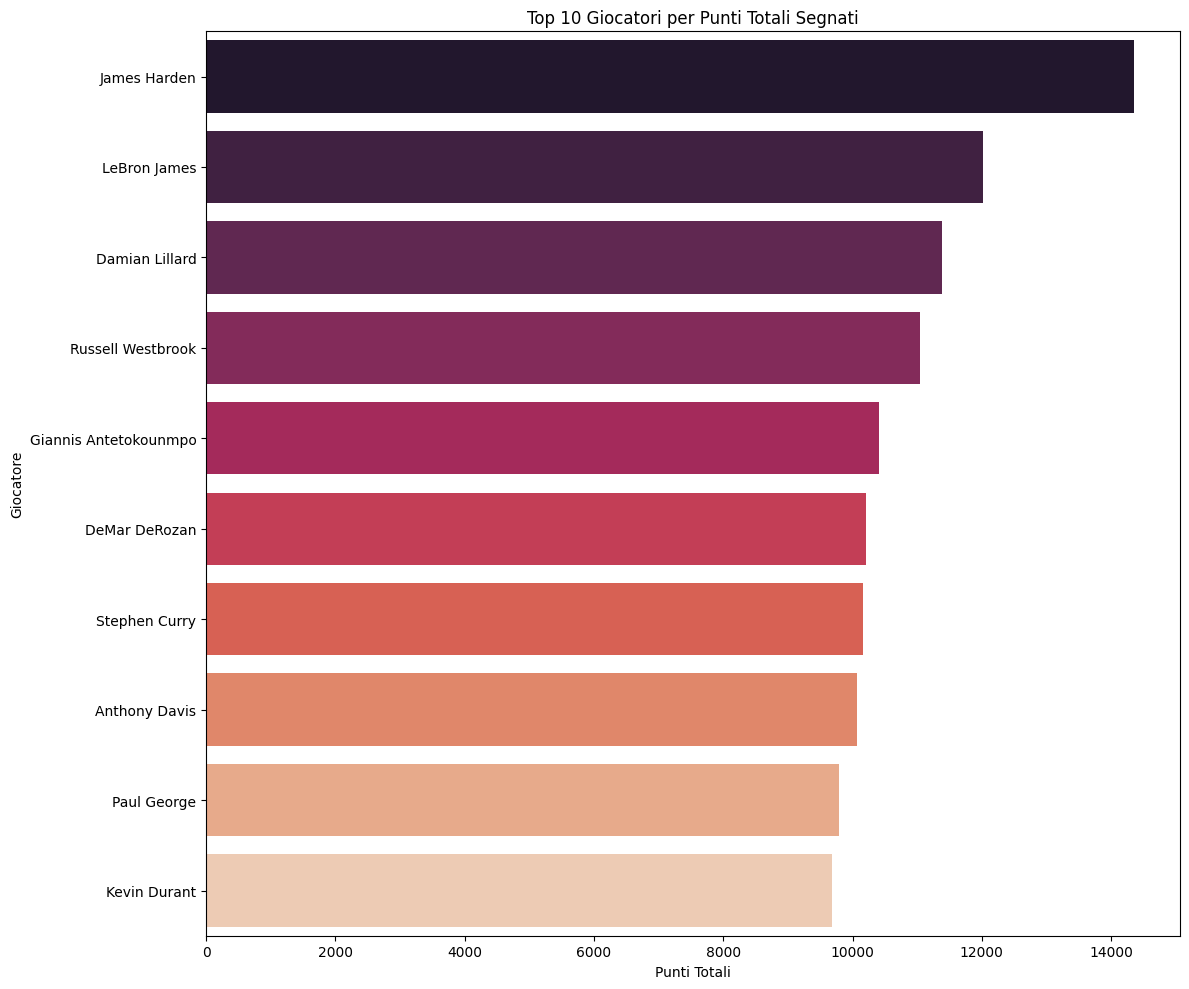

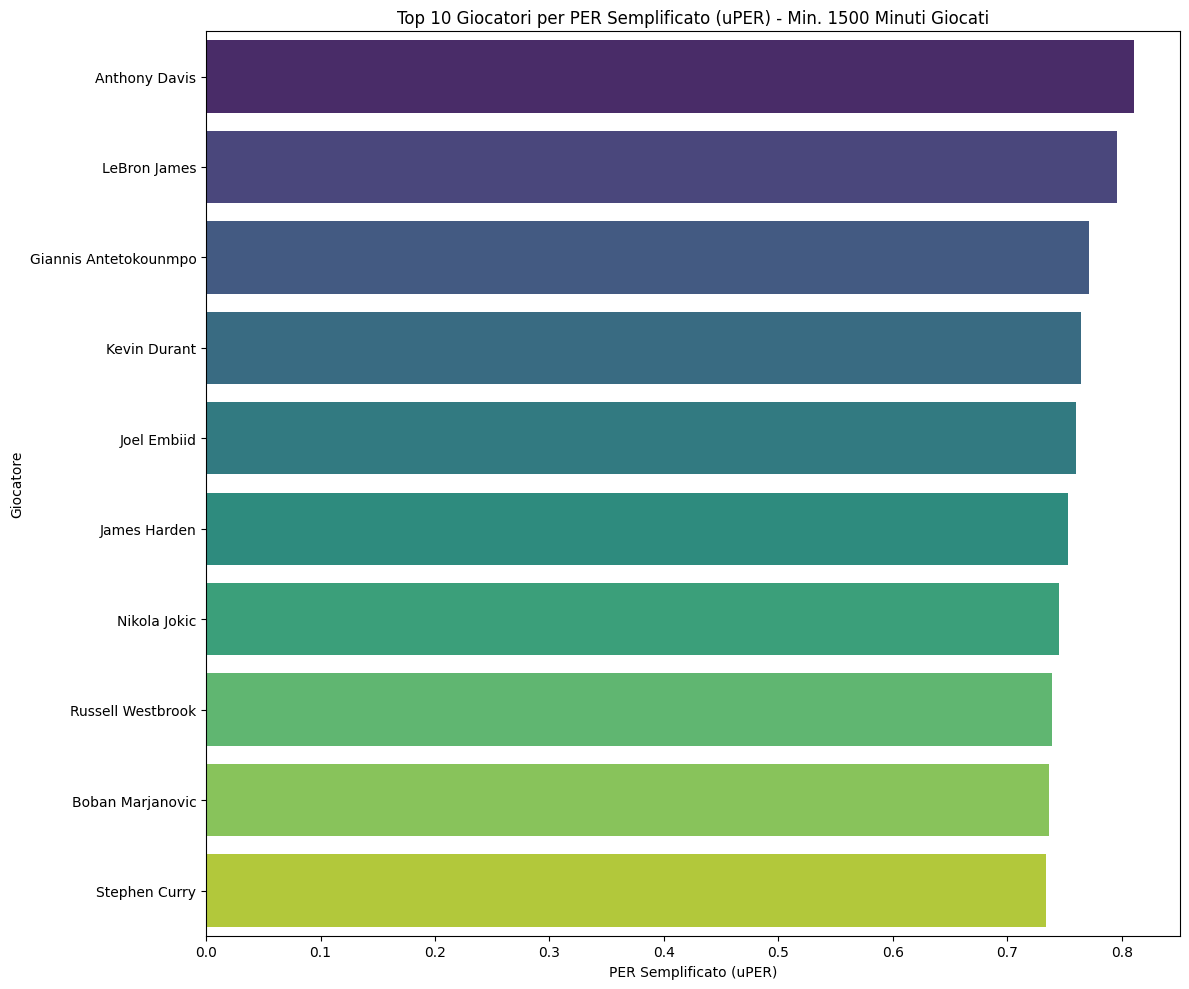

In [51]:
print("Analisi Influenza Giocatori: Punti Totali e PER")

# --- Dati per i grafici ---
players_total_points = []
scores_total_points = []
players_uper = []
scores_uper = []

# Classifica per Punti Totali Segnati
# ------------------------------------
print("\n--- Calcolo Punti Totali per Giocatore ---")
try:
    with driver.session(database=db_name) as session:
        # Query per Punti Totali di un giocatore 
        total_points_query = """
            MATCH (p:Player)-[rel:PLAYED_IN_GAME]->(g:Game)
            WHERE rel.minutesPlayed > 0
            RETURN p.name AS playerName, 
                   p.playerId AS playerId, 
                   sum(rel.points) AS totalPointsScored
            ORDER BY totalPointsScored DESC
            LIMIT 10
        """
        result_total_points = session.run(total_points_query)
        print("\nTop 10 Giocatori per Punti Totali Segnati:")
        for record in result_total_points:
            players_total_points.append(record['playerName'])
            scores_total_points.append(record['totalPointsScored'])
            print(f"  Giocatore: {record['playerName']} (ID: {record['playerId']}), Punti Totali: {record['totalPointsScored']}")

except Exception as e:
    print(f"Errore durante il calcolo dei Punti Totali: {e}")

# Classifica per PER Semplificato (uPER)
# ------------------------------------------
# uPER = (1 / minuti_giocati_totali) * 
#        (Punti_tot + Rimbalzi_tot + Assist_tot + Rubate_tot + Stoppate_tot 
#         - (Tiri_campo_tentati_tot - Tiri_campo_segnati_tot)  // Tiri sbagliati
#         - (Tiri_liberi_tentati_tot - Tiri_liberi_segnati_tot) // Tiri liberi sbagliati
#         - Palle_perse_tot 
#         - Falli_personali_tot)
# Considereremo solo giocatori con un numero minimo di minuti giocati per rendere il PER più stabile.
MIN_TOTAL_MINUTES_FOR_PER = 1500

print(f"\n--- Calcolo PER Semplificato (uPER) per Giocatore (min {MIN_TOTAL_MINUTES_FOR_PER} minuti totali) ---")
try:
    with driver.session(database=db_name) as session:
        uper_query = f"""
            MATCH (p:Player)-[rel:PLAYED_IN_GAME]->(g:Game)
            WITH p, 
                 sum(rel.points) AS totalPts,
                 sum(rel.reb) AS totalReb,
                 sum(rel.ast) AS totalAst,
                 sum(rel.stl) AS totalStl,
                 sum(rel.blk) AS totalBlk,
                 sum(rel.fga) AS totalFGA, // Field Goals Attempted
                 sum(rel.fgm) AS totalFGM, // Field Goals Made
                 sum(rel.fta) AS totalFTA, // Free Throws Attempted
                 sum(rel.ftm) AS totalFTM, // Free Throws Made
                 sum(rel.turnovers) AS totalTO,
                 sum(rel.personalFouls) AS totalPF,
                 sum(rel.minutesPlayed) / 60.0 AS totalMinutes // Converte secondi in minuti
            WHERE totalMinutes > {MIN_TOTAL_MINUTES_FOR_PER} // Filtro per minuti totali giocati
            WITH p, totalPts, totalReb, totalAst, totalStl, totalBlk,
                 (totalFGA - totalFGM) AS totalMissedFG,
                 (totalFTA - totalFTM) AS totalMissedFT,
                 totalTO, totalPF, totalMinutes
            // Calcolo uPER
            WITH p, totalMinutes,
                 (totalPts + totalReb + totalAst + totalStl + totalBlk - totalMissedFG - totalMissedFT - totalTO - totalPF) AS positiveContribution
            WHERE totalMinutes > 0 // Evita divisione per zero se il filtro sopra non fosse stringente
            RETURN p.name AS playerName, 
                   p.playerId AS playerId, 
                   (positiveContribution / totalMinutes) AS uPER,
                   totalMinutes
            ORDER BY uPER DESC
            LIMIT 10
        """
        result_uper = session.run(uper_query)
        print("\nTop 10 Giocatori per PER Semplificato (uPER):")
        for record in result_uper:
            players_uper.append(record['playerName'])
            scores_uper.append(record['uPER'])
            print(f"  Giocatore: {record['playerName']} (ID: {record['playerId']}), uPER: {record['uPER']:.2f} (Minuti Totali: {record['totalMinutes']:.0f})")

except Exception as e:
    print(f"Errore durante il calcolo del PER Semplificato: {e}")

# --- Visualizzazione Grafici ---
print("\n--- Creazione Grafici per Punti Totali e PER Semplificato ---")

# Grafico per Punti Totali
if players_total_points and scores_total_points:
    plt.figure(figsize=(12, 10))
    sns.barplot(x=scores_total_points, y=players_total_points, palette="rocket", hue=players_total_points, legend=False)
    plt.title('Top 10 Giocatori per Punti Totali Segnati')
    plt.xlabel('Punti Totali')
    plt.ylabel('Giocatore')
    plt.tight_layout()
    plt.show()
else:
    print("Dati non sufficienti per generare il grafico dei Punti Totali.")

# Grafico per PER Semplificato
if players_uper and scores_uper:
    plt.figure(figsize=(12, 10))
    sns.barplot(x=scores_uper, y=players_uper, palette="viridis", hue=players_uper, legend=False)
    plt.title(f'Top 10 Giocatori per PER Semplificato (uPER) - Min. {MIN_TOTAL_MINUTES_FOR_PER} Minuti Giocati')
    plt.xlabel('PER Semplificato (uPER)')
    plt.ylabel('Giocatore')
    plt.tight_layout()
    plt.show()
else:
    print("Dati non sufficienti per generare il grafico del PER Semplificato.")

Le classifiche dirette basate su metriche di performance aggregate come "Punti Totali" e "uPER" hanno immediatamente prodotto liste di giocatori (James Harden, LeBron James, Stephen Curry, Anthony Davis, ecc.) molto più allineate con la percezione comune di "stelle NBA" e giocatori di grande impatto.

Procediamo ora a salvare uPer come proprietà sui nodi :Player per semplificare le successive analisi

In [7]:
# Nome della nuova proprietà che creeremo sui nodi :Player
uper_node_property = 'uPER_score' 
MIN_TOTAL_MINUTES_FOR_PER_SAVE = 1500 

print(f"\n--- Salvataggio di '{uper_node_property}' sui nodi :Player ---")
print(f"(Solo per giocatori con più di {MIN_TOTAL_MINUTES_FOR_PER_SAVE} minuti totali giocati)")

try:
    with driver.session(database=db_name) as session:
        # Prima, per pulizia, rimuoviamo la proprietà se esiste già da esecuzioni precedenti
        try:
            remove_prop_query = f"""
                MATCH (p:Player)
                WHERE p.{uper_node_property} IS NOT NULL
                REMOVE p.{uper_node_property}
                RETURN count(p) AS nodesUpdated
            """
            removed_result = session.run(remove_prop_query).single()
            if removed_result and removed_result['nodesUpdated'] is not None:
                 print(f"Proprietà '{uper_node_property}' rimossa da {removed_result['nodesUpdated']} nodi (se esisteva).")
            else:
                print(f"Nessuna proprietà '{uper_node_property}' preesistente trovata da rimuovere o la query non ha restituito un conteggio.")
        except Exception as e_remove:
            print(f"Info: Non è stato possibile rimuovere la proprietà '{uper_node_property}': {e_remove}")


        # Calcolo e salvataggio di uPER
        # Usiamo coalesce per le somme per gestire eventuali null se un giocatore non avesse alcune stats
        # e per impostare uPER a 0 per chi non raggiunge la soglia o per cui il calcolo dà null.
        save_uper_query = f"""
            MATCH (p:Player)-[rel:PLAYED_IN_GAME]->(g:Game)
            WITH p, 
                 sum(coalesce(rel.points, 0)) AS totalPts,
                 sum(coalesce(rel.reb, 0)) AS totalReb,
                 sum(coalesce(rel.ast, 0)) AS totalAst,
                 sum(coalesce(rel.stl, 0)) AS totalStl,
                 sum(coalesce(rel.blk, 0)) AS totalBlk,
                 sum(coalesce(rel.fga, 0)) AS totalFGA, 
                 sum(coalesce(rel.fgm, 0)) AS totalFGM, 
                 sum(coalesce(rel.fta, 0)) AS totalFTA, 
                 sum(coalesce(rel.ftm, 0)) AS totalFTM, 
                 sum(coalesce(rel.turnovers, 0)) AS totalTO,
                 sum(coalesce(rel.personalFouls, 0)) AS totalPF,
                 sum(coalesce(rel.minutesPlayed, 0)) / 60.0 AS totalMinutes
            // Calcolo uPER solo per chi ha giocato abbastanza e ha minuti validi
            WITH p, totalMinutes,
                 CASE
                     WHEN totalMinutes > {MIN_TOTAL_MINUTES_FOR_PER_SAVE} THEN
                         (totalPts + totalReb + totalAst + totalStl + totalBlk - 
                          (totalFGA - totalFGM) - (totalFTA - totalFTM) - 
                          totalTO - totalPF) / totalMinutes
                     ELSE 0 // Imposta uPER a 0 per chi non raggiunge la soglia
                 END AS calculated_uPER
            SET p.{uper_node_property} = calculated_uPER
            RETURN count(p) AS players_updated, 
                   avg(p.{uper_node_property}) AS avg_uper_set,
                   min(p.{uper_node_property}) AS min_uper_set,
                   max(p.{uper_node_property}) AS max_uper_set
        """        
        result_save_uper = session.run(save_uper_query).single()
        if result_save_uper:
            print(f"Proprietà '{uper_node_property}' calcolata e settata per i giocatori eleggibili.")
            print(f"  Numero di aggregazioni giocatore processate: {result_save_uper.get('players_updated', 'N/A')}")
            print(f"  Media uPER settata: {result_save_uper.get('avg_uper_set', 'N/A'):.2f}")
            print(f"  Min uPER settata: {result_save_uper.get('min_uper_set', 'N/A'):.2f}")
            print(f"  Max uPER settata: {result_save_uper.get('max_uper_set', 'N/A'):.2f}")
            
            # Conteggio separato per vedere quanti hanno effettivamente la proprietà > 0
            count_with_prop_query = f"""
                MATCH (p:Player)
                WHERE p.{uper_node_property} > 0
                RETURN count(p) AS count_with_positive_uper
            """
            count_res = session.run(count_with_prop_query).single()
            if count_res:
                 print(f"Numero di giocatori con '{uper_node_property}' > 0: {count_res['count_with_positive_uper']}")
        else:
            print(f"Qualcosa è andato storto, nessun risultato dal salvataggio di '{uper_node_property}'.")

except Exception as e:
    print(f"Errore GRAVE durante il salvataggio di '{uper_node_property}': {e}")



--- Salvataggio di 'uPER_score' sui nodi :Player ---
(Solo per giocatori con più di 1500 minuti totali giocati)
Proprietà 'uPER_score' rimossa da 1212 nodi (se esisteva).
Proprietà 'uPER_score' calcolata e settata per i giocatori eleggibili.
  Numero di aggregazioni giocatore processate (potrebbe non essere il totale dei nodi :Player se alcuni non hanno partite): 1212
  Media uPER settata: 0.16
  Min uPER settata: 0.00
  Max uPER settata: 0.81
  Numero di giocatori con 'uPER_score' > 0: 499


## Ridefinizione dell'influenza del grafo: PageRank e DegreeCentrality su un grafo ponderato dalla performance

Per combinare l'analisi strutturale della rete con la performance individuale, è stato creato un **nuovo grafo proiettato in GDS**, denominato `player_interactions_weighted_by_perf`.

**Caratteristiche del Nuovo Grafo Proiettato:**
*   **Nodi:** Giocatori (`:Player`).
*   **Relazioni (`SHARED_GAME`):** Collegano due giocatori se hanno partecipato alla stessa partita.
*   **Peso delle Relazioni (Modificato):** Il peso di ogni relazione `SHARED_GAME` tra due giocatori (`p1`, `p2`) è stato ridefinito per incorporare sia la frequenza della loro interazione sia la loro performance individuale (tramite `uPER_score`). Il nuovo peso è stato calcolato come:

    $$
    \text{peso relazione} = (\text{partite condivise tra }p_1\text{e }p_2) \times (\frac{1}{2}(p_{1PER}+p_{2PER}))
    $$


    (Utilizzando un piccolo valore di default per l'uPER_score se mancante o zero per evitare che il peso diventi nullo impropriamente).

Su questo nuovo grafo, verranno rieseguiti gli algoritmi di Degree Centrality (pesata) e PageRank e ci aspetteremo dei risultati diversi dal caso di studio precedente


--- Creazione Nuova Proiezione Grafo GDS: 'player_interactions_weighted_by_perf' ---
Le relazioni 'SHARED_GAME' saranno pesate da: count(partite) * media(uPER_p1, uPER_p2)
Eventuale grafo 'player_interactions_weighted_by_perf' preesistente cancellato o non trovato.
Proiezione del grafo 'player_interactions_weighted_by_perf' creata con successo.
  Nodi proiettati: 1769
  Relazioni proiettate: 284949

--- Esecuzione PageRank su 'player_interactions_weighted_by_perf' (pesi relazioni modificati) ---

Top 10 Giocatori per PageRank (su 'player_interactions_weighted_by_perf' con pesi relazioni basati su uPER):
  Giocatore: Kobe Bryant (ID: 977), PageRank: 19.8887 (uPER: 0.35)
  Giocatore: Tayshaun Prince (ID: 2419), PageRank: 15.9310 (uPER: 0.19)
  Giocatore: Tim Duncan (ID: 1495), PageRank: 12.9458 (uPER: 0.49)
  Giocatore: Chris Bosh (ID: 2547), PageRank: 7.7898 (uPER: 0.53)
  Giocatore: Kevin Garnett (ID: 708), PageRank: 6.6745 (uPER: 0.00)
  Giocatore: Luis Scola (ID: 2449), PageRank: 5.

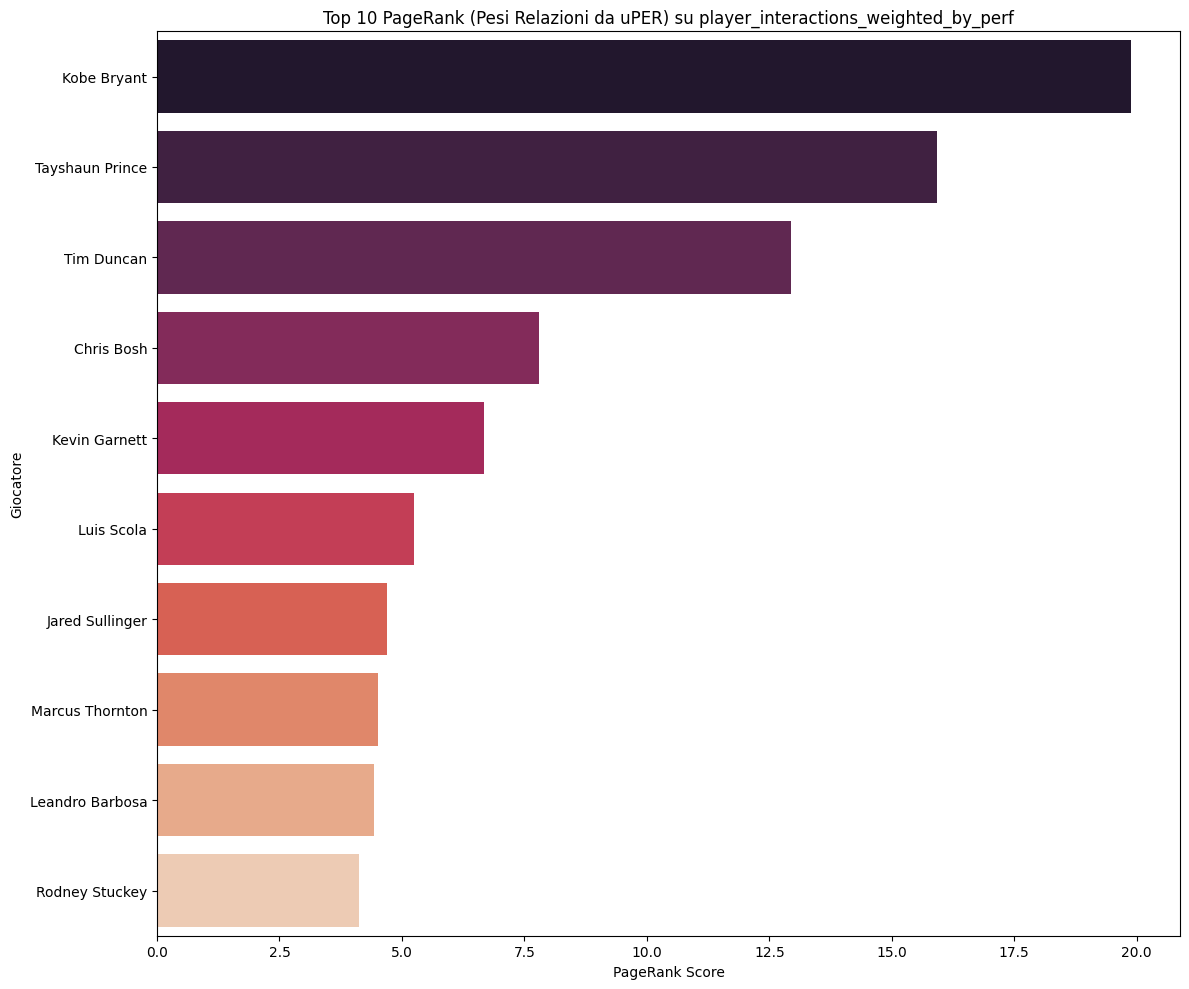

In [33]:
uper_property_on_node = 'uPER_score' 
new_gds_graph_name = 'player_interactions_weighted_by_perf'

# Valore di default per uPER_score se è null o zero, per evitare che il peso della relazione diventi zero
# solo perché un giocatore ha uPER nullo.
default_uper_for_weight_calc = 0.05

print(f"\n--- Creazione Nuova Proiezione Grafo GDS: '{new_gds_graph_name}' ---")
print(f"Le relazioni 'SHARED_GAME' saranno pesate da: count(partite) * media(uPER_p1, uPER_p2)")

try:
    with driver.session(database=db_name) as session:
        # Controllo se il nuovo grafo esiste già
        try:
            session.run(f"CALL gds.graph.drop('{new_gds_graph_name}', false)")
            print(f"Eventuale grafo '{new_gds_graph_name}' preesistente cancellato o non trovato.")
        except Exception as e_drop:
            print(f"Info: problema nel cancellare il grafo '{new_gds_graph_name}' (potrebbe non esistere): {e_drop}")

        # Creazione della nuova proiezione
        node_query = "MATCH (p:Player) RETURN id(p) AS id, labels(p) AS labels"
        
        # La relationshipQuery ora calcola il peso usando uPER_score
        # Usiamo coalesce per gestire uPER_score null o mancanti
        relationship_query = f"""
            MATCH (p1:Player)-[:PLAYED_IN_GAME]->(g:Game)<-[:PLAYED_IN_GAME]-(p2:Player)
            WHERE id(p1) < id(p2)
            WITH p1, p2, count(g) AS gamesCount
            RETURN id(p1) AS source, 
                   id(p2) AS target, 
                   "SHARED_GAME" AS type, 
                   gamesCount * (
                       (coalesce(p1.{uper_property_on_node}, {default_uper_for_weight_calc}) + 
                        coalesce(p2.{uper_property_on_node}, {default_uper_for_weight_calc})) / 2.0
                   ) AS weight 
        """

        project_result = session.run(
            "CALL gds.graph.project.cypher($graphName, $nodeQuery, $relationshipQuery)",
            graphName=new_gds_graph_name, 
            nodeQuery=node_query, 
            relationshipQuery=relationship_query
        ).single()

        if project_result:
            print(f"Proiezione del grafo '{project_result['graphName']}' creata con successo.")
            print(f"  Nodi proiettati: {project_result['nodeCount']}")
            print(f"  Relazioni proiettate: {project_result['relationshipCount']}")
        else:
            print(f"Errore: la proiezione del grafo '{new_gds_graph_name}' non ha restituito statistiche.")
            raise Exception(f"Proiezione GDS '{new_gds_graph_name}' fallita")


        # Esecuzione di PageRank su questo nuovo grafo
        print(f"\n--- Esecuzione PageRank su '{new_gds_graph_name}' (pesi relazioni modificati) ---")
        players_pagerank_new_weights = []
        scores_pagerank_new_weights = []

        pagerank_new_query = f"""
            CALL gds.pageRank.stream('{new_gds_graph_name}', {{
                relationshipWeightProperty: 'weight', // Ora 'weight' è il nostro peso calcolato con uPER
                maxIterations: 20,
                dampingFactor: 0.85
            }})
            YIELD nodeId, score
            WITH gds.util.asNode(nodeId) AS playerNode, score AS pageRankScore
            RETURN playerNode.name AS playerName, 
                   playerNode.playerId AS playerId, 
                   pageRankScore,
                   playerNode.{uper_property_on_node} AS uPER_for_player 
            ORDER BY pageRankScore DESC
            LIMIT 10
        """
        result_pagerank_nw = session.run(pagerank_new_query)
        print(f"\nTop 10 Giocatori per PageRank (su '{new_gds_graph_name}' con pesi relazioni basati su uPER):")
        for record in result_pagerank_nw:
            players_pagerank_new_weights.append(record['playerName'])
            scores_pagerank_new_weights.append(record['pageRankScore'])
            uper_val = record.get('uPER_for_player')
            uper_display = f"{uper_val:.2f}" if uper_val is not None else "N/A"
            print(f"  Giocatore: {record['playerName']} (ID: {record['playerId']}), PageRank: {record['pageRankScore']:.4f} (uPER: {uper_display})")
        
        # Grafico
        if players_pagerank_new_weights and scores_pagerank_new_weights:
            plt.figure(figsize=(12, 10))
            sns.barplot(x=scores_pagerank_new_weights, y=players_pagerank_new_weights, palette="rocket", hue=players_pagerank_new_weights, legend=False)
            plt.title(f'Top 10 PageRank (Pesi Relazioni da uPER) su {new_gds_graph_name}')
            plt.xlabel('PageRank Score')
            plt.ylabel('Giocatore')
            plt.tight_layout()
            plt.show()
        else:
            print("Nessun dato per il grafico PageRank con nuovi pesi.")

except Exception as e:
    print(f"Errore durante la creazione della nuova proiezione GDS o l'esecuzione di PageRank: {e}")


### PageRank su `player_interactions_weighted_by_perf`

**Interpretazione:** Questo PageRank, ora influenzato dai pesi delle relazioni che codificano la performance, misura la centralità di un giocatore in questa nuova rete "arricchita". Un alto punteggio suggerisce un giocatore che non solo ha giocato con molti altri, ma ha anche interagito significativamente (spesso e/o con alta performance reciproca) con altri giocatori che sono a loro volta performanti e ben connessi.  

*   La presenza di leggende come Kobe Bryant, Tim Duncan, Kevin Garnett, Chris Bosh e giocatori chiave di squadre di successo come Tayshaun Prince è molto significativa. Sebbene il dataset copra 2015-2019 (periodo in cui alcuni di questi erano alla fine della carriera), i loro `uPER_score` e le loro interazioni con giocatori ancora attivi e performanti in quel periodo contribuiscono al loro punteggio.  
Se il loro `uPER_score` nel periodo 2015-2019 fosse basso o zero (es. Kevin Garnett con uPER 0.00), il loro alto PageRank deriva principalmente dalla forza delle interazioni ponderate con altri giocatori molto performanti con cui hanno condiviso il campo, anche se le loro statistiche personali in quelle poche partite finali potrebbero non essere state stellari. Questo evidenzia come PageRank consideri l'importanza dei "vicini".  

*   Giocatori come Luis Scola, Jared Sullinger, Marcus Thornton, Leandro Barbosa, Rodney Stuckey sono veterani o giocatori di ruolo che hanno avuto carriere solide, spesso giocando per più squadre e quindi accumulando interazioni con una vasta gamma di giocatori, e il cui uPER o l'uPER dei loro partner di interazione ha contribuito a dare peso a queste connessioni.



--- Esecuzione Degree Centrality (Pesata) su 'player_interactions_weighted_by_perf' ---
Il peso delle relazioni in questo grafo è: count(partite) * media(uPER_p1, uPER_p2)
Grafo GDS 'player_interactions_weighted_by_perf' trovato.

Top 15 Giocatori per Degree Centrality (Pesata su 'player_interactions_weighted_by_perf'):
  Giocatore: Giannis Antetokounmpo (ID: 203507), Grado Pesato: 5718.15 (uPER: 0.77)
  Giocatore: LeBron James (ID: 2544), Grado Pesato: 5201.88 (uPER: 0.80)
  Giocatore: Al Horford (ID: 201143), Grado Pesato: 4934.14 (uPER: 0.55)
  Giocatore: Anthony Davis (ID: 203076), Grado Pesato: 4882.56 (uPER: 0.81)
  Giocatore: Rudy Gobert (ID: 203497), Grado Pesato: 4865.85 (uPER: 0.63)
  Giocatore: Tobias Harris (ID: 202699), Grado Pesato: 4549.71 (uPER: 0.49)
  Giocatore: Julius Randle (ID: 203944), Grado Pesato: 4467.40 (uPER: 0.54)
  Giocatore: Draymond Green (ID: 203110), Grado Pesato: 4327.16 (uPER: 0.53)
  Giocatore: JaVale McGee (ID: 201580), Grado Pesato: 4250.70 (uPER:

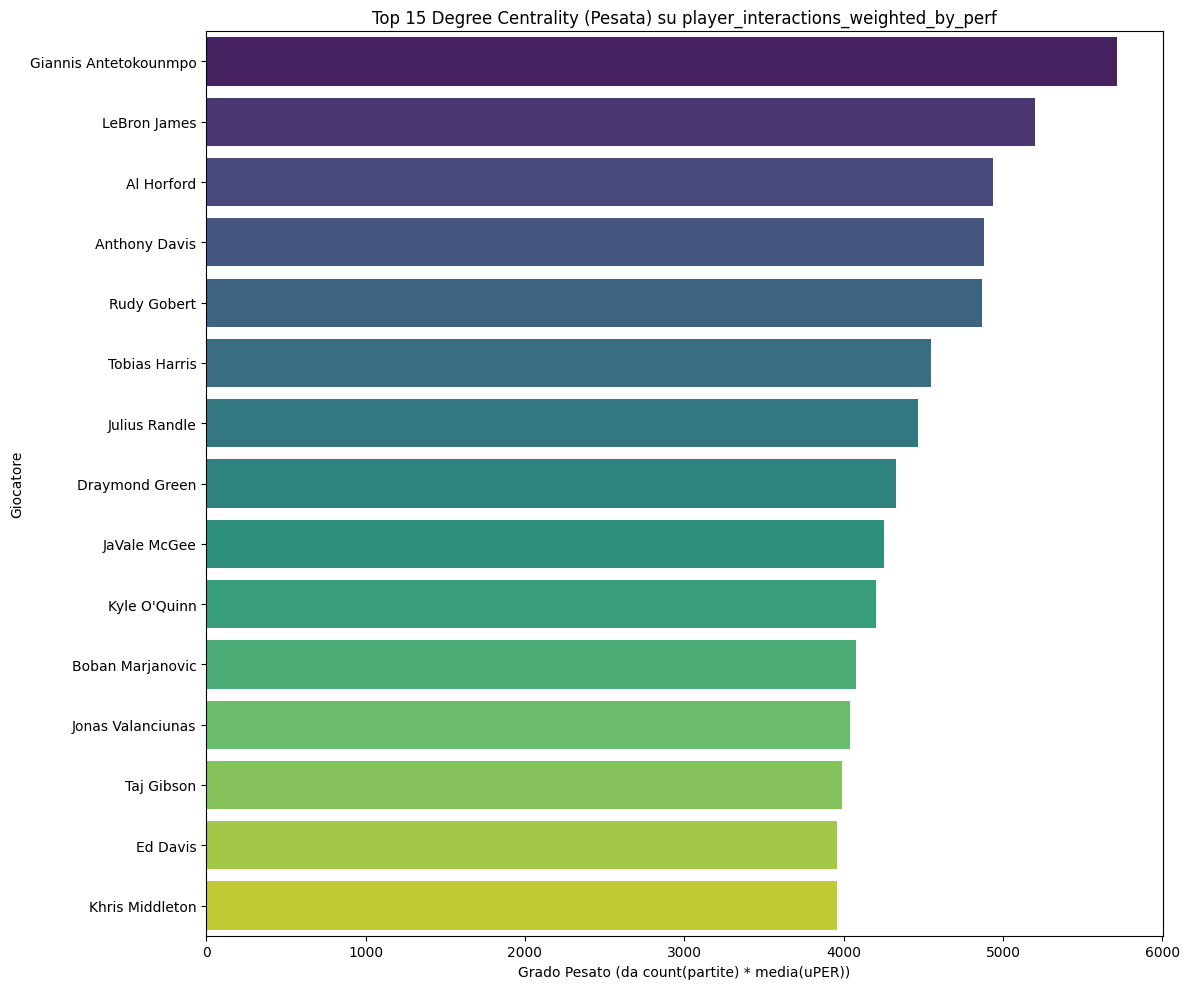

In [ ]:
# Nome del grafo GDS su cui eseguire Degree Centrality
gds_graph_for_degree = 'player_interactions_weighted_by_perf'
uper_property_on_node_ref = 'uPER_score' 

print(f"\n--- Esecuzione Degree Centrality (Pesata) su '{gds_graph_for_degree}' ---")
print(f"Il peso delle relazioni in questo grafo è: count(partite) * media(uPER_p1, uPER_p2)")

players_degree_new_graph = []
scores_degree_new_graph = []

try:
    with driver.session(database=db_name) as session:
        # Controlliamo prima se il grafo GDS esiste
        check_graph_exists_query = f"CALL gds.graph.exists('{gds_graph_for_degree}') YIELD exists RETURN exists"
        graph_exists = session.run(check_graph_exists_query).single()['exists']

        if not graph_exists:
            print(f"ERRORE: Il grafo GDS '{gds_graph_for_degree}' non esiste. Crealo prima di eseguire questa cella.")
        else:
            print(f"Grafo GDS '{gds_graph_for_degree}' trovato.")
            
            degree_new_graph_query = f"""
                CALL gds.degree.stream('{gds_graph_for_degree}', {{
                    relationshipWeightProperty: 'weight' // 'weight' è il nostro peso calcolato con uPER e conteggio partite
                }})
                YIELD nodeId, score
                WITH gds.util.asNode(nodeId) AS playerNode, score AS weightedDegree
                RETURN playerNode.name AS playerName, 
                       playerNode.playerId AS playerId, 
                       weightedDegree,
                       playerNode.{uper_property_on_node_ref} AS uPER_for_player
                ORDER BY weightedDegree DESC
                LIMIT 15
            """
            result_degree_ng = session.run(degree_new_graph_query)
            print(f"\nTop 15 Giocatori per Degree Centrality (Pesata su '{gds_graph_for_degree}'):")
            for record in result_degree_ng:
                players_degree_new_graph.append(record['playerName'])
                scores_degree_new_graph.append(record['weightedDegree'])
                uper_val_ref = record.get('uPER_for_player')
                uper_display_ref = f"{uper_val_ref:.2f}" if uper_val_ref is not None else "N/A"
                print(f"  Giocatore: {record['playerName']} (ID: {record['playerId']}), Grado Pesato: {record['weightedDegree']:.2f} (uPER: {uper_display_ref})")
            
            # Grafico
            if players_degree_new_graph and scores_degree_new_graph:
                plt.figure(figsize=(12, 10))
                sns.barplot(x=scores_degree_new_graph, y=players_degree_new_graph, palette="viridis", hue=players_degree_new_graph, legend=False)
                plt.title(f'Top 15 Degree Centrality (Pesata) su {gds_graph_for_degree}')
                plt.xlabel('Grado Pesato (da count(partite) * media(uPER))')
                plt.ylabel('Giocatore')
                plt.tight_layout()
                plt.show()
            else:
                print("Nessun dato per il grafico Degree Centrality sul nuovo grafo.")

except Exception as e:
    print(f"Errore durante l'esecuzione di Degree Centrality sul nuovo grafo: {e}")


### Degree Centrality (Pesata) su `player_interactions_weighted_by_perf`

*   **Interpretazione:** Questa metrica ora somma i "pesi compositi" delle interazioni di un giocatore. Un alto grado pesato in questo grafo indica un giocatore che ha avuto un grande volume di "interazioni di qualità".   
Ossia, ha giocato spesso e/o con molti giocatori diversi, e queste interazioni sono state ulteriormente valorizzate dalla performance (uPER) sua e dei giocatori con cui ha interagito.
    *   È interessante notare come giocatori come Giannis, LeBron, AD (alto uPER) siano in cima, indicando che le loro numerose interazioni sono anche "potenziate" dalla loro alta performance.
    *   La presenza di giocatori come Al Horford, Rudy Gobert, Tobias Harris, Julius Randle, Draymond Green suggerisce giocatori che combinano un alto volume di gioco/interazioni con una performance solida. Inoltre questi giocatori essendo di ruolo (titolari) si scontrano spesso con giocatori avversari anch'essi di ruolo (e quindi performanti)

# Conclusione dell'analisi

Riguardando i risultati ottenuti dalle nuove analisi possiamo dire che:

*   **PageRank Iniziale:** Utile per l'analisi topologica e la scoperta di comunità dense e isolate, ma fuorviante come misura di "influenza NBA" globale.
*   **Degree Centrality Iniziale:** Indicava volume di co-partecipazioni.
*   **Punti Totali / uPER:** Misure eccellenti e dirette della performance individuale e dell'efficienza, che si allineano bene con la nozione di "giocatore stella".
*   **Degree Centrality su Grafo Ponderato da uPER:** Misura il "volume di interazioni di qualità", combinando frequenza e performance. Fornisce una lista di giocatori che sono sia molto attivi sia performanti/connessi a giocatori performanti.
*   **PageRank su Grafo Ponderato da uPER:** Fornisce la misura di "influenza propagata nella rete di giocatori performanti". Considera non solo le connessioni dirette di un giocatore e la loro qualità, ma anche la qualità e la connettività dei suoi vicini, e così via. La classifica risultante (Kobe, Duncan, ecc.) suggerisce che sta catturando un senso di importanza storica e di rete all'interno del sottoinsieme di giocatori più performanti e delle loro interazioni.

In conclusione, modificando la definizione dei pesi delle relazioni nel grafo proiettato per includere una metrica di performance individuale (uPER), siamo riusciti a far sì che gli algoritmi di centralità basati su grafo (come PageRank e Degree Centrality) producessero classifiche che riflettono più da vicino l'"influenza" di un giocatore nel contesto NBA. Questo approccio combina la connettività nella rete con la qualità individuale e la qualità dei giocatori con cui si interagisce, offrendo una visione più ricca e sfumata rispetto all'analisi puramente strutturale. 

---

<br>
<br>

# Analisi della costruzione delle squadre NBA e correlazione con il successo

L'obiettivo di questa analisi è investigare come differenti archetipi di costruzione delle squadre NBA, definiti in base alla qualità media dei giocatori e alla presenza di "stelle", si correlano con il successo della squadra, misurato in termini di numero totale di vittorie in una stagione.

### Feature Engineering per Squadra-Stagione

Per caratterizzare ogni squadra in ogni stagione considerata (2015-2019), sono state definite e calcolate le seguenti feature a livello di squadra-stagione:

*   **`avg_uPER`**: La media del Player Efficiency Rating Semplificato (uPER) di tutti i giocatori che hanno giocato per una squadra in una data stagione e che avevano un `uPER_score` calcolato e positivo. Questa metrica rappresenta la "qualità media" del talento a disposizione della squadra.
*   **`num_stars_uPER`**: Il numero di giocatori in una squadra, per una data stagione, il cui `uPER_score` superava una soglia predefinita (`UPER_STAR_THRESHOLD = 0.60`). Questa metrica quantifica la presenza di giocatori d'élite o "stelle".
*   **`total_wins`**: Il numero totale di partite vinte da una squadra in una data stagione, considerando tutte le partite presenti nel dataset per quella `SEASON` (che include regular season, pre-stagione e playoff).

In [ ]:
print("\n--- Calcolo Feature Squadra-Stagione (uPER e Vittorie) ---")

# Soglia per definire un giocatore "stella" in base al suo uPER_score
UPER_STAR_THRESHOLD = 0.60 

# Stagioni di interesse
SEASONS = [2015, 2016, 2017, 2018, 2019] # Come da filtro iniziale del dataset

team_season_features_data = []

try:
    with driver.session(database=db_name) as session:
        query = f"""
        UNWIND $seasons_list AS s // Iteriamo sulle stagioni
        MATCH (t:Team)

        // Sottoselezione per calcolare le vittorie della squadra 't' nella stagione 's'
        CALL {{
            WITH t, s // Passiamo 't' e 's' alla subquery

            // Calcola home wins
            OPTIONAL MATCH (t)-[:HOSTED_GAME]->(g_home:Game {{season: s}})
            WHERE g_home.homeTeamWins = true 
            WITH t, s, count(g_home) AS hw // hw è home_wins per questa squadra/stagione

            // Calcola away wins
            OPTIONAL MATCH (t)-[:VISITED_GAME]->(g_away:Game {{season: s}})
            WHERE g_away.homeTeamWins = false
            WITH hw, count(g_away) AS aw // aw è away_wins.

            RETURN hw + aw AS season_total_wins
        }}

        // Sottoselezione per calcolare le feature basate su uPER per squadra 't' nella stagione 's'
        CALL {{
            WITH t, s // Passiamo 't' e 's' alla subquery
            
            OPTIONAL MATCH (p:Player)-[r_played:PLAYED_IN_GAME]->(g:Game {{season: s}})
            WHERE r_played.teamId = t.teamId AND p.uPER_score IS NOT NULL AND p.uPER_score > 0 
            
            WITH t, s, p, avg(p.uPER_score) AS player_uPER_in_season
            
            RETURN avg(player_uPER_in_season) AS season_avg_uPER,
                   count(CASE WHEN player_uPER_in_season > $uper_threshold THEN p ELSE null END) AS season_num_stars
        }}

        RETURN t.teamId AS teamId, 
               t.nickname AS teamName, 
               s AS season, 
               coalesce(season_avg_uPER, 0.0) AS avg_uPER, 
               coalesce(season_num_stars, 0) AS num_stars_uPER, 
               coalesce(season_total_wins, 0) AS total_wins
        ORDER BY s, t.nickname
        """
        
        result = session.run(query, seasons_list=SEASONS, uper_threshold=UPER_STAR_THRESHOLD)
        team_season_features_data = [record.data() for record in result]

except Exception as e:
    print(f"Errore durante il calcolo delle feature Squadra-Stagione: {{e}}")

if team_season_features_data:
    df_team_season_features = pd.DataFrame(team_season_features_data)
    print(f"Calcolate feature per {len(df_team_season_features)} combinazioni squadra-stagione.")
    
    if not df_team_season_features.empty:
        print("\nPrime righe del DataFrame generato:")
        print(df_team_season_features.head())
        
        print("\nUltime righe del DataFrame generato:")
        print(df_team_season_features.tail())

        print(f"\nStatistiche per avg_uPER: Sum={df_team_season_features['avg_uPER'].sum()}, Max={df_team_season_features['avg_uPER'].max()}")
        print(f"Statistiche per num_stars_uPER: Sum={df_team_season_features['num_stars_uPER'].sum()}, Max={df_team_season_features['num_stars_uPER'].max()}")
        print(f"Statistiche per total_wins: Sum={df_team_season_features['total_wins'].sum()}, Max={df_team_season_features['total_wins'].max()}")
            
        print("\nStatistiche descrittive per le feature numeriche:")
        print(df_team_season_features[['avg_uPER', 'num_stars_uPER', 'total_wins']].describe())

    else:
        print("Il DataFrame generato è vuoto.")
else:
    print("Nessun dato restituito dalla query o errore durante l'esecuzione.")


--- Calcolo Feature Squadra-Stagione (uPER e Vittorie) ---
Calcolate feature per 150 combinazioni squadra-stagione.

Prime righe del DataFrame generato:
       teamId   teamName  season  avg_uPER  num_stars_uPER  total_wins
0  1610612755      76ers    2015  0.415469               2          12
1  1610612749      Bucks    2015  0.401919               1          35
2  1610612741      Bulls    2015  0.401194               2          46
3  1610612739  Cavaliers    2015  0.398867               1          74
4  1610612738    Celtics    2015  0.406259               0          54

Ultime righe del DataFrame generato:
         teamId       teamName  season  avg_uPER  num_stars_uPER  total_wins
145  1610612760        Thunder    2019  0.386561               1          51
146  1610612750   Timberwolves    2019  0.372375               1          20
147  1610612757  Trail Blazers    2019  0.410658               3          38
148  1610612744       Warriors    2019  0.407514               1          

## Analisi dei Dati delle Feature Squadra-Stagione

Dopo aver calcolato le feature aggregate a livello di squadra-stagione (`avg_uPER`, `num_stars_uPER` e `total_wins`), il passo successivo è condurre un'Analisi Esplorativa dei Dati (EDA). L'obiettivo principale di questa fase è comprendere a fondo le caratteristiche di queste nuove metriche e le relazioni che intercorrono tra loro.

Nello specifico, attraverso l'EDA cercheremo di:

1.  **Analizzare le Distribuzioni Individuali**: Esamineremo come si distribuiscono i valori di `avg_uPER`, `num_stars_uPER` e `total_wins` nel nostro dataset. Questo ci aiuterà a capire i valori tipici, la presenza di eventuali anomalie o pattern particolari per ciascuna feature.
2.  **Investigare le Relazioni tra Feature**: Utilizzeremo grafici a dispersione (scatter plot) per visualizzare le relazioni tra coppie di feature, in particolare:
    *   Come `avg_uPER` si relaziona con `total_wins`.
    *   Come `num_stars_uPER` si relaziona con `total_wins`.
    *   Come `avg_uPER` si relaziona con `num_stars_uPER` (le due feature che intendiamo usare per il clustering).
3.  **Quantificare le Correlazioni**: Calcoleremo e visualizzeremo una matrice di correlazione per misurare la forza e la direzione delle relazioni lineari tra queste tre variabili chiave.

Questa analisi è cruciale per diversi motivi:
*   **Validare le Feature**: Confermare che le feature ingegnerizzate mostrino variabilità e relazioni sensate con il successo della squadra (misurato dalle vittorie).
*   **Preparare il Clustering**: Comprendere la struttura dei dati e le interazioni tra `avg_uPER` e `num_stars_uPER` è fondamentale per interpretare correttamente i risultati del successivo clustering K-Means e per assicurarsi che queste feature siano appropriate per identificare archetipi significativi di costruzione delle squadre.
*   **Ottenere Intuizioni Preliminari**: Anche prima del clustering, l'EDA può fornire spunti iniziali su come la qualità media e la presenza di stelle potrebbero influenzare le performance delle squadre.

Le visualizzazioni e le statistiche prodotte in questa fase guideranno l'interpretazione dei cluster che verranno identificati successivamente.


--- Passo 2 (Completamento): Analisi Esplorativa Dati (EDA) delle Feature Squadra-Stagione ---

Statistiche descrittive dettagliate (ripetizione per completezza):
         avg_uPER  num_stars_uPER  total_wins
count  150.000000      150.000000  150.000000
mean     0.395915        1.066667   45.480000
std      0.023682        0.931670   16.162646
min      0.335192        0.000000   12.000000
25%      0.382919        0.000000   34.250000
50%      0.393980        1.000000   45.000000
75%      0.410863        2.000000   56.000000
max      0.457928        4.000000   91.000000


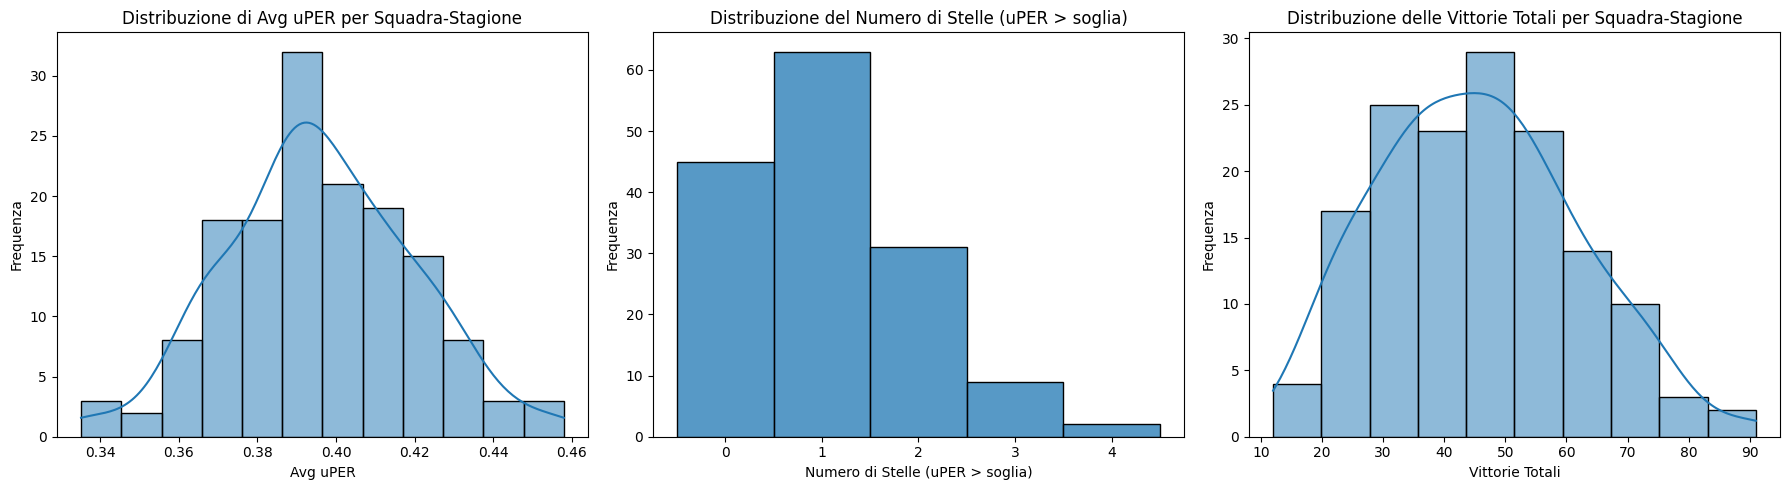

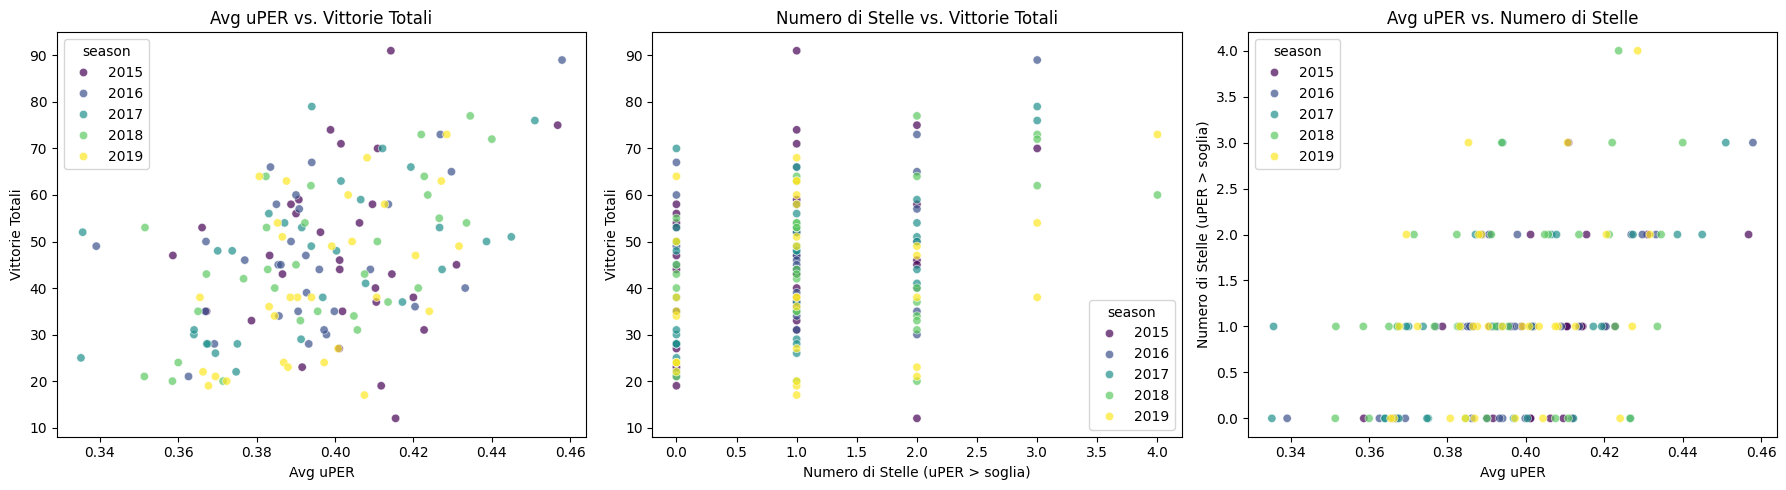

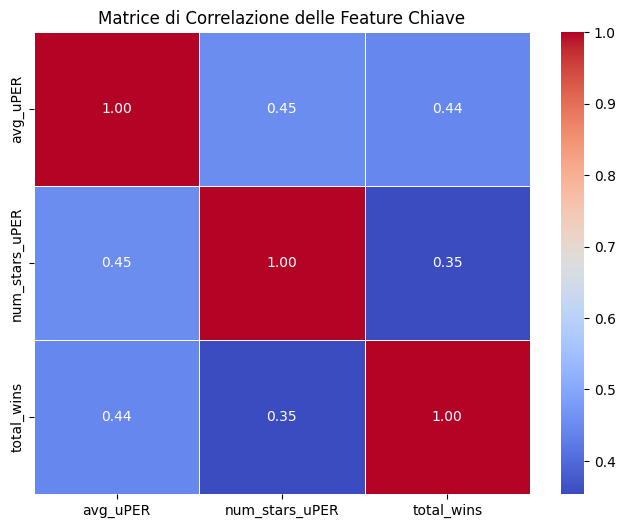

In [ ]:
if 'df_team_season_features' in locals() and not df_team_season_features.empty:
    print("\nStatistiche descrittive dettagliate (ripetizione per completezza):")
    print(df_team_season_features[['avg_uPER', 'num_stars_uPER', 'total_wins']].describe())

    # Visualizzazione delle distribuzioni delle feature
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(df_team_season_features['avg_uPER'], kde=True)
    plt.title('Distribuzione di Avg uPER per Squadra-Stagione')
    plt.xlabel('Avg uPER')
    plt.ylabel('Frequenza')

    plt.subplot(1, 3, 2)
    sns.histplot(df_team_season_features['num_stars_uPER'], discrete=True, kde=False) # discrete=True per conteggi interi
    plt.title('Distribuzione del Numero di Stelle (uPER > soglia)')
    plt.xlabel('Numero di Stelle (uPER > soglia)')
    plt.ylabel('Frequenza')

    plt.subplot(1, 3, 3)
    sns.histplot(df_team_season_features['total_wins'], kde=True)
    plt.title('Distribuzione delle Vittorie Totali per Squadra-Stagione')
    plt.xlabel('Vittorie Totali')
    plt.ylabel('Frequenza')

    plt.tight_layout()
    plt.show()

    # Visualizzazione delle relazioni tra feature (Scatter plots)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    sns.scatterplot(data=df_team_season_features, x='avg_uPER', y='total_wins', hue='season', palette='viridis', alpha=0.7)
    plt.title('Avg uPER vs. Vittorie Totali')
    plt.xlabel('Avg uPER')
    plt.ylabel('Vittorie Totali')

    plt.subplot(1, 3, 2)
    sns.scatterplot(data=df_team_season_features, x='num_stars_uPER', y='total_wins', hue='season', palette='viridis', alpha=0.7)
    plt.title('Numero di Stelle vs. Vittorie Totali')
    plt.xlabel('Numero di Stelle (uPER > soglia)')
    plt.ylabel('Vittorie Totali')


    plt.subplot(1, 3, 3)
    sns.scatterplot(data=df_team_season_features, x='avg_uPER', y='num_stars_uPER', hue='season', palette='viridis', alpha=0.7)
    plt.title('Avg uPER vs. Numero di Stelle')
    plt.xlabel('Avg uPER')
    plt.ylabel('Numero di Stelle (uPER > soglia)')

    plt.tight_layout()
    plt.show()

    # Matrice di Correlazione
    features_for_clustering = ['avg_uPER', 'num_stars_uPER']
    target_variable = ['total_wins']
    
    correlation_matrix = df_team_season_features[features_for_clustering + target_variable].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matrice di Correlazione delle Feature Chiave')
    plt.show()
else:
    print("DataFrame 'df_team_season_features' non trovato o vuoto")

## Interpretazione dei dati ottenuti:

Analizziamo attentamente i grafici ottenuti, in quanto ci guideranno per il passo di clustering.  

1. **Distribuzione di Avg uPER per Squadra-Stagione:**    
Questo istrogramma mostra come si distribuiscono i valori di avg_uPER tra le 150 combinazionisquadra-stagione. La distribuzione sembra approssimativamente normale.  Questo grafico mosrta una variabilità significativa nei valori di avg_uPER

2. **Distribuzione del Numero di Stelle (uPER > soglia):**   
Questo istogramma mostra la frequenza del numero di stelle (giocatori con uPER > 0.60) per ogni squadra-stagione, similmente a prima questa feature mostra variabilità.  
Ci sono squadre senza stelle, con una stella principale, o con un piccolo nucleo di stelle.

3. **Distribuzione delle Vittorie Totali per Squadra-Stagione:**  
Questo istogramma mostra come si distribuiscono i valori di total_wins tra tutte le 150 combinazioni, ci permette di notare che esiste una notevole dispersione nelle vittorie. 

4. **Avg uPER vs. Vittorie Totali:**  
Ogni punto in questo grafico rappresenta una singola squadra-stagione. La posizione orizzontale del punto è data dal suo avg_uPER, e la posizione verticale è data dalle sue total_wins. I colori dei punti distinguono le diverse stagioni (2015-2019), come indicato dalla legenda.  
Si nota una tendenza positiva generale, infatti man mano che ci si sposta verso destra nell'asse X (ossia all'aumentare di avg_uPER) si hanno valori tendenzialmente più alti sull'asse Y (ossia tendono ad avere più vittorie).  

5. **Numero di Stelle vs. Vittorie Totali:**  
Si osserva anche qui una tendenza positiva: le squadre con un numero maggiore di stelle (punti più a destra) tendono ad avere un numero maggiore di vittorie (punti più in alto). Ad esempio, le squadre con 0 stelle sono distribuite su una vasta gamma di vittorie, ma le loro vittorie massime sono generalmente inferiori a quelle delle squadre con 3 o 4 stelle.


6. **Avg uPER vs. Numero di Stelle:**  
Ogni punto nel grafico è una squadra-stagione, posizionato in base al suo avg_uPER (asse X) e al suo num_stars_uPER (asse Y).  
le squadre con avg_uPER più alto tendono ad avere anche un numero maggiore di stelle. Questo ha senso: le stelle contribuiscono ad alzare la media, e le squadre con buona qualità generale potrebbero attrarre o sviluppare stelle.
Tuttavia la relazione non è perfetta, si possono infatti osservare:
    - Squadre in alto a destra: alto avg_uPER e più stelle (chiamate 'super team').
    - Squadre con avg_uPER relativamente alto ma 0 stelle (squadre profonde e coese senza una superstar definita).
    - Squadre con avg_uPER medio e 1 stella (squadre costruite attorno a un leader).  

7. **Matrice di Correlazione delle Feature Chiave:**  
Questa heatmap visualizza i coefficienti di correlazione di Pearson tra ogni coppia delle tre feature chiave: avg_uPER, num_stars_uPER, e total_wins.  
- avg_uPER vs total_wins (0.44): Correlazione positiva moderata 
- num_stars_uPER vs total_wins (0.35): Correlazione positiva
- avg_uPER vs num_stars_uPER (0.45): Correlazione positiva moderata 
I risultati mostrano che avg_uPER e num_stars_uPER sono correlate tra loro (0.45), ma non troppo fortemente; questo ci indica che sono rilevanti per definire il successo di una squadra.


--- Clustering delle Squadre-Stagioni ---
Feature selezionate e standardizzate.


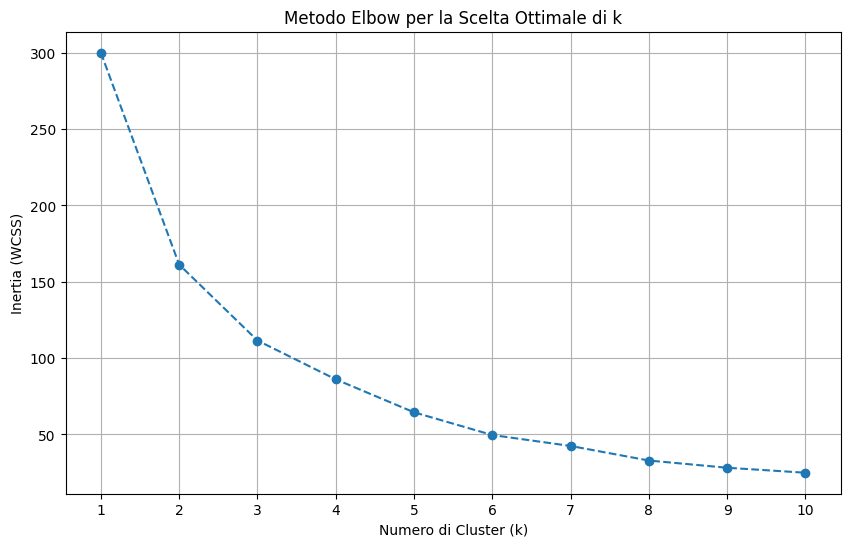

k scelto per K-Means: 4
Algoritmo K-Means eseguito con k=4. Etichette dei cluster aggiunte al DataFrame.


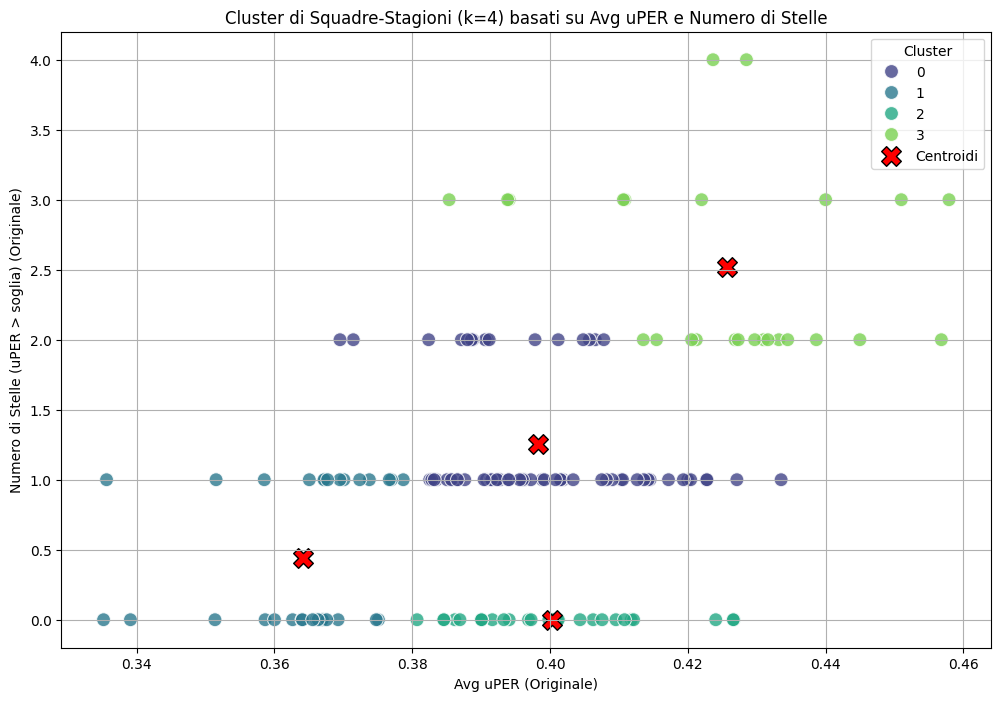


Analisi preliminare delle caratteristiche medie per cluster:
         avg_uPER  num_stars_uPER  total_wins
cluster                                      
3        0.425744        2.520000   58.040000
0        0.398225        1.257576   46.696970
2        0.400324        0.000000   44.037037
1        0.364127        0.437500   34.375000

Conteggio elementi per cluster:
cluster
0    66
1    32
2    27
3    25
Name: count, dtype: int64


In [37]:
print("\n--- Clustering delle Squadre-Stagioni ---")

if 'df_team_season_features' in locals() and not df_team_season_features.empty:
    
    # Selezionare le feature per il clustering
    features_for_clustering = ['avg_uPER', 'num_stars_uPER']
    X = df_team_season_features[features_for_clustering].copy()

    # Standardizzare le feature
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("Feature selezionate e standardizzate.")

    # metodo "Elbow" per trovare un buon numero di cluster (k)
    inertia = [] # somma del quadrato delle distanze del sample dal cluster più vicino
    possible_k_values = range(1, 11) # da 1 a 10 cluster

    for k in possible_k_values:
        kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init='auto') 
        kmeans_temp.fit(X_scaled)
        inertia.append(kmeans_temp.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(possible_k_values, inertia, marker='o', linestyle='--')
    plt.title('Metodo Elbow per la Scelta Ottimale di k')
    plt.xlabel('Numero di Cluster (k)')
    plt.ylabel('Inertia (WCSS)') # Within-Cluster Sum of Squares
    plt.xticks(possible_k_values)
    plt.grid(True)
    plt.show()

    # inserire il k ottimale osservando il grafico Elbow
    chosen_k = int(input("Osserva il grafico Elbow qui sopra. Inserisci il numero di cluster (k): ") or "4") # 4 è dimostrato un buon numero in questo caso
    print(f"k scelto per K-Means: {chosen_k}")

    # eseguire K-Means con il k scelto
    kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init='auto')
    df_team_season_features['cluster'] = kmeans.fit_predict(X_scaled)
    
    print(f"Algoritmo K-Means eseguito con k={chosen_k}. Etichette dei cluster aggiunte al DataFrame.")

    # visualizzazione cluster
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_team_season_features, 
                    x='avg_uPER', 
                    y='num_stars_uPER', 
                    hue='cluster', 
                    palette=sns.color_palette("viridis", n_colors=chosen_k),
                    s=100, # dimensione dei punti
                    alpha=0.8)
    
    # aggiungiamo i centroidi al grafico
    # i centroidi sono nelle coordinate scalate, quindi dobbiamo invertirne la trasformazione per plottarli sulle feature originali
    centroids_scaled = kmeans.cluster_centers_
    centroids_original_scale = scaler.inverse_transform(centroids_scaled)
    plt.scatter(centroids_original_scale[:, 0], centroids_original_scale[:, 1], 
                marker='X', s=200, color='red', ec='black', label='Centroidi')

    plt.title(f'Cluster di Squadre-Stagioni (k={chosen_k}) basati su Avg uPER e Numero di Stelle')
    plt.xlabel('Avg uPER (Originale)')
    plt.ylabel('Numero di Stelle (uPER > soglia) (Originale)')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

    # analisi iniziale delle caratteristiche dei cluster
    print("\nAnalisi preliminare delle caratteristiche medie per cluster:")
    cluster_analysis = df_team_season_features.groupby('cluster')[['avg_uPER', 'num_stars_uPER', 'total_wins']].mean().sort_values(by='total_wins', ascending=False)
    print(cluster_analysis)

    print("\nConteggio elementi per cluster:")
    print(df_team_season_features['cluster'].value_counts().sort_index())

else:
    print("DataFrame 'df_team_season_features' non trovato o vuoto. Assicurati che le celle precedenti siano state eseguite correttamente.")


--- Interpretazione Finale dei Cluster e Correlazione con le Vittorie ---

Caratteristiche Medie per Archetipo di Squadra (ordinato per vittorie medie decrescenti):
         avg_uPER  num_stars_uPER  total_wins
cluster                                      
3        0.425744        2.520000   58.040000
0        0.398225        1.257576   46.696970
2        0.400324        0.000000   44.037037
1        0.364127        0.437500   34.375000
Nomi proposti per i cluster (basati sull'ordinamento per vittorie):
Cluster 3 -> A: Elite/Super-Team (Vittorie Alte)
Cluster 0 -> B: Solide con Stella (Vittorie Buone)
Cluster 2 -> C: Coese Senza Stelle (Vittorie Medie)
Cluster 1 -> D: In Difficoltà (Vittorie Basse)


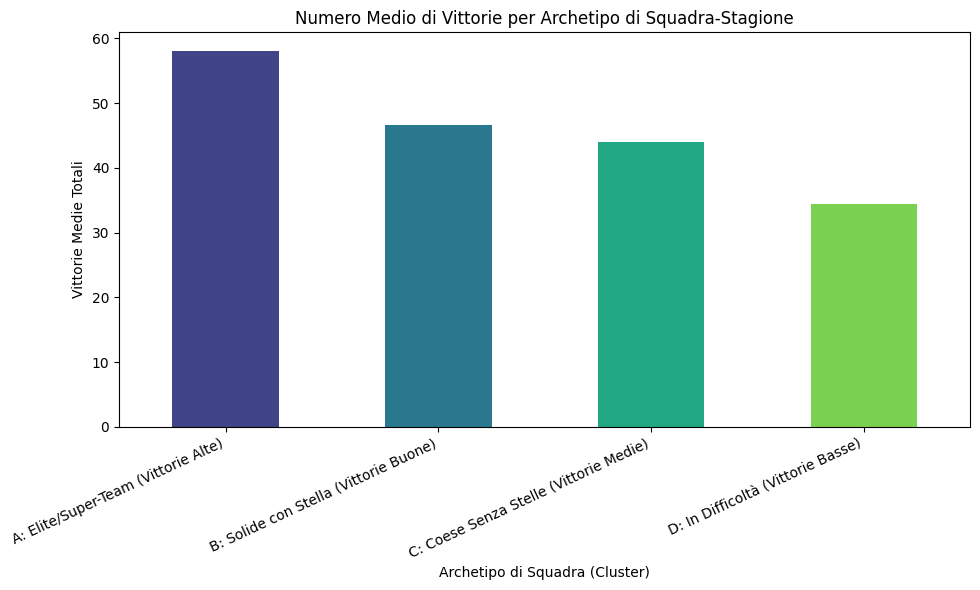

/var/folders/mz/2x3r_7v12sl_hfwrgd4nzpm00000gn/T/ipykernel_44415/3263585823.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_team_season_features,


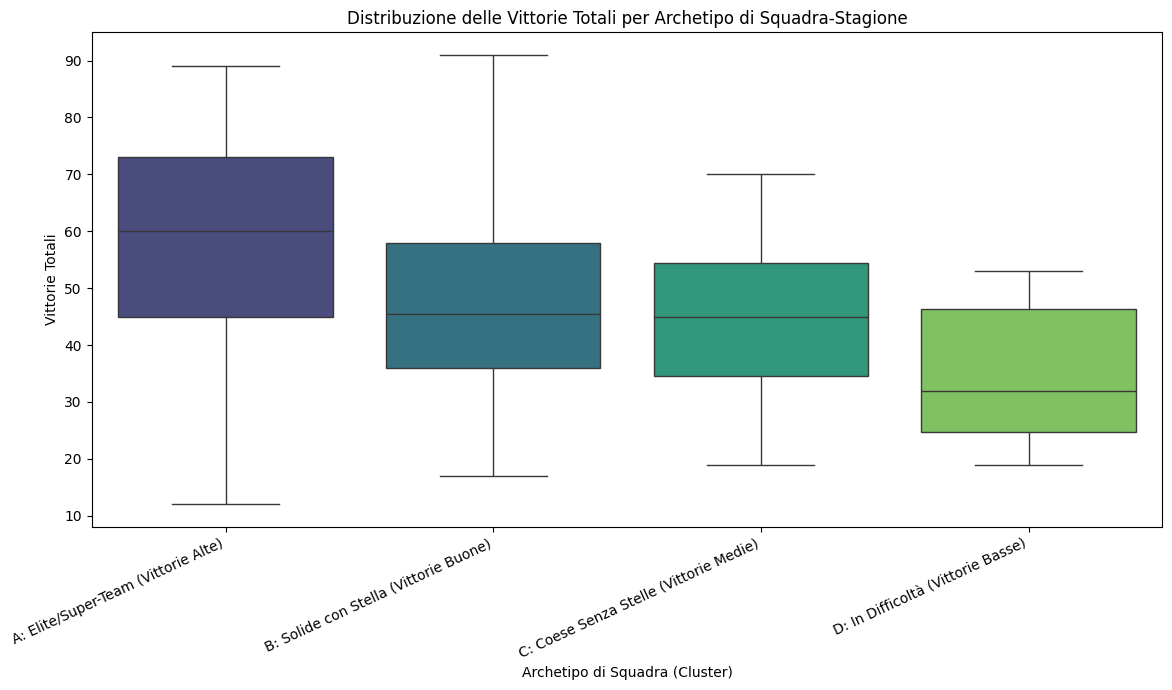

In [38]:
print("\n--- Interpretazione Finale dei Cluster e Correlazione con le Vittorie ---")

if 'df_team_season_features' in locals() and 'cluster' in df_team_season_features.columns:

    cluster_analysis_means = df_team_season_features.groupby('cluster')[['avg_uPER', 'num_stars_uPER', 'total_wins']].mean().sort_values(by='total_wins', ascending=False)
    
    # Definiamo nomi più descrittivi per i cluster basati sulla nostra analisi
    # Questa mappatura è basata sull'output del KMeans:
    # Cluster 3: Elite
    # Cluster 0: Solide con Stella
    # Cluster 2: Coese Senza Stelle
    # Cluster 1: In Difficoltà
    
    # Determina l'ordine corretto dei cluster basato sulle vittorie medie
    ordered_clusters = cluster_analysis_means.index.tolist()
    cluster_names_map = {}
    # Assegna i nomi in base all'ordinamento per vittorie
    if len(ordered_clusters) == 4:
        cluster_names_map[ordered_clusters[0]] = "A: Elite/Super-Team (Vittorie Alte)"      # Cluster 3
        cluster_names_map[ordered_clusters[1]] = "B: Solide con Stella (Vittorie Buone)"    # Cluster 0
        cluster_names_map[ordered_clusters[2]] = "C: Coese Senza Stelle (Vittorie Medie)"   # Cluster 2
        cluster_names_map[ordered_clusters[3]] = "D: In Difficoltà (Vittorie Basse)"        # Cluster 1
    else: # Fallback se il numero di cluster non è 4 (caso input diverso)
        for i, cl_idx in enumerate(ordered_clusters):
            cluster_names_map[cl_idx] = f"Cluster {cl_idx} (Rank {i+1} per Vittorie)"

    df_team_season_features['cluster_archetype'] = df_team_season_features['cluster'].map(cluster_names_map)
    

    print("\nCaratteristiche Medie per Archetipo di Squadra (ordinato per vittorie medie decrescenti):")
    print(cluster_analysis_means) 
    print("Nomi proposti per i cluster (basati sull'ordinamento per vittorie):")
    for cl_idx in ordered_clusters:
        print(f"Cluster {cl_idx} -> {cluster_names_map.get(cl_idx, f'Cluster {cl_idx}')}")


    # grafico a Barre delle Vittorie Medie per Archetipo
    plt.figure(figsize=(10, 6))
    
    # crea una Series con le vittorie medie indicizzata dai nomi degli archetipi
    # e ordina per i nomi (che iniziano con A, B, C, D per mantenere l'ordine logico)
    wins_by_archetype = df_team_season_features.groupby('cluster_archetype')['total_wins'].mean().sort_index()

    wins_by_archetype.plot(kind='bar', color=sns.color_palette("viridis", len(wins_by_archetype)))
    plt.title('Numero Medio di Vittorie per Archetipo di Squadra-Stagione')
    plt.ylabel('Vittorie Medie Totali')
    plt.xlabel('Archetipo di Squadra (Cluster)')
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()

    # box Plot della Distribuzione delle Vittorie per Archetipo
    plt.figure(figsize=(12, 7))
    # ordina i box plot in modo coerente (A, B, C, D)
    sorted_archetypes = sorted(df_team_season_features['cluster_archetype'].unique())
    sns.boxplot(data=df_team_season_features, 
                x='cluster_archetype', 
                y='total_wins', 
                palette=sns.color_palette("viridis", len(sorted_archetypes)),
                order=sorted_archetypes) # Assicura l'ordine corretto dei box
    plt.title('Distribuzione delle Vittorie Totali per Archetipo di Squadra-Stagione')
    plt.ylabel('Vittorie Totali')
    plt.xlabel('Archetipo di Squadra (Cluster)')
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame 'df_team_season_features' o la colonna 'cluster' non trovati.")

## 5. Analisi e Interpretazione dei Cluster (Archetipi di Squadra)

Dopo aver eseguito l'algoritmo K-Means con `k=4` e aver assegnato ogni squadra-stagione a un cluster, abbiamo analizzato le caratteristiche medie di `avg_uPER`, `num_stars_uPER` e, soprattutto, `total_wins` per ciascun gruppo. Per facilitare l'interpretazione, i cluster sono stati ordinati in base al numero medio di vittorie decrescenti e rinominati con etichette descrittive.

**Caratteristiche Medie per Archetipo:**

| Cluster ID (Originale) | Archetipo Proposto                       | Avg uPER Medio | Num Stelle Medio | Vittorie Medie Totali |
| :--------------------- | :--------------------------------------- | :------------- | :--------------- | :-------------------- |
| 3                      | A: Elite/Super-Team (Vittorie Alte)      | ~0.426         | ~2.52            | **~58.04**            |
| 0                      | B: Solide con Stella (Vittorie Buone)    | ~0.398         | ~1.26            | **~46.70**            |
| 2                      | C: Coese Senza Stelle (Vittorie Medie)   | ~0.400         | 0.00             | **~44.04**            |
| 1                      | D: In Difficoltà (Vittorie Basse)        | ~0.364         | ~0.44            | **~34.38**            |


**Visualizzazione del Successo per Archetipo:**

I grafici generati (diagramma a barre delle vittorie medie e box plot della distribuzione delle vittorie) illustrano chiaramente come questi archetipi si correlano con il successo sul campo:

1.  **Numero Medio di Vittorie per Archetipo (Grafico a Barre)**:
    *   Conferma una netta gerarchia nel successo. L'archetipo **"A: Elite/Super-Team"** (caratterizzato da alto `avg_uPER` e il maggior numero di stelle) domina con una media di circa 58 vittorie.
    *   Segue l'archetipo **"B: Solide con Stella"** con una media di circa 47 vittorie, dimostrando l'efficacia di avere una stella principale supportata da una buona qualità generale.
    *   È interessante notare che l'archetipo **"C: Coese Senza Stelle"**, pur non avendo giocatori che superano la soglia di "stella" definita, raggiunge una media di circa 44 vittorie, superando le squadre "In Difficoltà". Questo suggerisce che una buona qualità media diffusa nel roster può compensare, almeno in parte, la mancanza di una superstar.
    *   Infine, l'archetipo **"D: In Difficoltà"** (basso `avg_uPER` e poche/nessuna stella) si posiziona all'ultimo posto con una media di circa 34 vittorie.

2.  **Distribuzione delle Vittorie Totali per Archetipo (Box Plot)**:
    *   Questo grafico offre una visione più granulare, mostrando non solo la media ma l'intera distribuzione delle vittorie per ciascun archetipo.
    *   Si osserva che, sebbene le medie siano distinte, esiste una certa sovrapposizione nei range di vittorie tra gli archetipi. Ad esempio, le migliori squadre del gruppo "C" possono raggiungere un numero di vittorie simile alle squadre di medio-bassa classifica del gruppo "B".
    *   L'archetipo "A" mostra la sua superiorità con la mediana e l'intero range interquartile posizionati più in alto.
    *   La dispersione all'interno di ogni archetipo indica che, anche all'interno di una stessa filosofia di costruzione, altri fattori influenzano il numero finale di vittorie.

**Interpretazione degli Archetipi:**

Basandoci sulle caratteristiche medie (`avg_uPER`, `num_stars_uPER`) e sul loro successo medio (`total_wins`), possiamo definire i seguenti archetipi di squadra:

*   **Cluster A ("Squadre d'Élite / Super-Team")**: Alta qualità media e un numero significativo di stelle (2-3 in media). Associate al maggior successo.
*   **Cluster B ("Squadre Solide con una Stella Guida")**: Buona qualità media e circa 1-2 stelle. Squadre competitive costruite attorno a una stella principale e un buon cast di supporto.
*   **Cluster C ("Squadre Coese Senza Stelle d'Élite")**: Buona qualità media, ma nessuna stella secondo la soglia uPER. Raggiungono un successo rispettabile, probabilmente grazie a profondità e gioco di squadra.
*   **Cluster D ("Squadre in Difficoltà / Ricostruzione")**: Bassa qualità media e mancanza di talento d'élite. Associate al minor numero di vittorie.

Questi risultati forniscono delucidazioni concrete su come diverse strategie di costruzione del roster NBA si traducono in differenti livelli di performance, come misurato dal numero di vittorie stagionali.

---

## Analisi della Mobilità dei Giocatori e Correlazione con la Performance (uPER)

In questa sezione, esaminiamo il comportamento dei giocatori NBA nel periodo 2015-2019 in termini di "nomadismo" (quanti giocatori cambiano squadra) e "fedeltà" (quanti giocatori rimangono con la stessa squadra). L'obiettivo è duplice:

1.  **Identificare i Giocatori "Nomadi":** Trovare i giocatori che hanno militato nel maggior numero di squadre diverse durante l'arco temporale considerato.
2.  **Identificare i Giocatori "Fedeli":** Trovare i giocatori che sono rimasti affiliati a una singola squadra per tutto il periodo.

Per entrambi i gruppi, analizzeremo la loro performance individuale, misurata tramite il `uPER_score` (Player Efficiency Rating Semplificato e Normalizzato), per investigare se esiste una correlazione tra la tendenza a cambiare squadra e il livello di performance. In particolare, vogliamo osservare:

*   Se i giocatori che cambiano frequentemente squadra tendono ad avere un `uPER` mediamente più basso o più alto.
*   Come si distribuisce l'`uPER` tra i giocatori che sono rimasti fedeli alla stessa squadra.


In [53]:
print("--- Analisi dei Giocatori Nomadi (che hanno cambiato più squadre) ---")
# query per trovare i giocatori che hanno giocato per più di una squadra,
# ordinati per numero di squadre e poi per uPER.

query_nomadi = """
MATCH (p:Player)
CALL {
    WITH p
    MATCH (p)-[r_played_in_game:PLAYED_IN_GAME]->(:Game)
    RETURN count(DISTINCT r_played_in_game.teamId) AS numTeams
}
WITH p, numTeams // Portiamo numTeams nello scope principale
WHERE numTeams > 1 // Nomadi: hanno giocato per più di una squadra
RETURN p.playerId AS playerId,
       p.name AS playerName,
       numTeams AS numTeamsPlayed, 
       p.uPER_score AS uPER
ORDER BY numTeamsPlayed DESC, uPER DESC
LIMIT 10
"""

nomadi_list = []
with driver.session(database=db_name) as session:
    result_nomadi = session.run(query_nomadi)
    for record in result_nomadi:
        nomadi_list.append(record.data())

if nomadi_list:
    df_nomadi = pd.DataFrame(nomadi_list)
    print(f"Trovati {len(df_nomadi)} giocatori che hanno militato in più di una squadra:")
    print(df_nomadi.to_string())

    if 'uPER' in df_nomadi.columns and not df_nomadi['uPER'].isnull().all():
        print("\nStatistiche descrittive dell'uPER per questi giocatori nomadi:")
        print(df_nomadi['uPER'].describe())
    else:
        print("\nColonna 'uPER' non trovata o tutti i valori sono nulli per i giocatori nomadi.")
else:
    print("Nessun giocatore nomade trovato con i criteri specificati.")

print("\n\n--- Analisi dei Giocatori Fedeli (che hanno giocato sempre per la stessa squadra) ---")
# Query per trovare i giocatori che hanno giocato per una sola squadra,
# ordinati per uPER decrescente.
query_fedeli = """
MATCH (p:Player)
CALL {
    WITH p
    MATCH (p)-[r_played_in_game:PLAYED_IN_GAME]->(:Game)
    RETURN count(DISTINCT r_played_in_game.teamId) AS numTeams
}
WITH p, numTeams 
WHERE numTeams = 1 // Fedeli: hanno giocato per esattamente una squadra
RETURN p.playerId AS playerId,
       p.name AS playerName,
       p.uPER_score AS uPER
ORDER BY uPER DESC
LIMIT 10 // Mostra i top 25 fedeli (per uPER)
"""

fedeli_list = []
with driver.session(database=db_name) as session:
    result_fedeli = session.run(query_fedeli)
    for record in result_fedeli:
        fedeli_list.append(record.data())

if fedeli_list:
    df_fedeli = pd.DataFrame(fedeli_list)
    print(f"Trovati {len(df_fedeli)} giocatori che hanno militato in una sola squadra:")
    print(df_fedeli.to_string())

    if 'uPER' in df_fedeli.columns and not df_fedeli['uPER'].isnull().all():
        print("\nStatistiche descrittive dell'uPER per questi giocatori fedeli:")
        print(df_fedeli['uPER'].describe())
    else:
        print("\nColonna 'uPER' non trovata o tutti i valori sono nulli per i giocatori fedeli.")

    # Conteggio totale dei giocatori fedeli
    query_count_fedeli_total = """
    MATCH (p:Player)
    CALL {
        WITH p
        MATCH (p)-[r:PLAYED_IN_GAME]->(:Game)
        RETURN count(DISTINCT r.teamId) AS numTeams
    }
    WITH p, numTeams
    WHERE numTeams = 1
    RETURN count(p) AS totalFedeli
    """
    with driver.session(database=db_name) as session:
        total_fedeli_result = session.run(query_count_fedeli_total).single()
        if total_fedeli_result:
            print(f"\nNumero totale di giocatori fedeli (una sola squadra): {total_fedeli_result['totalFedeli']}")

else:
    print("Nessun giocatore fedele trovato con i criteri specificati.")

# Conteggio totale dei giocatori nomadi
query_count_nomadi_total = """
MATCH (p:Player)
CALL {
    WITH p
    MATCH (p)-[r:PLAYED_IN_GAME]->(:Game)
    RETURN count(DISTINCT r.teamId) AS numTeams
}
WITH p, numTeams
WHERE numTeams > 1
RETURN count(p) AS totalNomadi
"""
with driver.session(database=db_name) as session:
    total_nomadi_result = session.run(query_count_nomadi_total).single()
    if total_nomadi_result:
        print(f"Numero totale di giocatori nomadi (più di una squadra): {total_nomadi_result['totalNomadi']}")

--- Analisi dei Giocatori Nomadi (che hanno cambiato più squadre) ---
Trovati 10 giocatori che hanno militato in più di una squadra:
   playerId        playerName  numTeamsPlayed      uPER
0    203092      Tyler Zeller               7  0.411225
1    201145        Jeff Green               7  0.347832
2    203516   James Ennis III               7  0.287088
3    203477     Isaiah Canaan               7  0.268620
4    101141    Ersan Ilyasova               6  0.401620
5    203930   Sean Kilpatrick               6  0.373012
6    202362  Lance Stephenson               6  0.364739
7    203895      Jordan McRae               6  0.355283
8   1626188        Quinn Cook               6  0.355057
9   1627362     Briante Weber               6  0.000000

Statistiche descrittive dell'uPER per questi giocatori nomadi:
count    10.000000
mean      0.316448
std       0.119741
min       0.000000
25%       0.302274
50%       0.355170
75%       0.370944
max       0.411225
Name: uPER, dtype: float64


--- An

## Risultati e Interpretazione: Mobilità dei Giocatori e uPER

L'analisi ha prodotto due elenchi principali: i giocatori più "nomadi" (coloro che hanno giocato per il maggior numero di squadre diverse tra il 2015 e il 2019) e i giocatori "fedeli" (coloro che hanno giocato per una sola squadra in questo periodo), entrambi correlati con il loro `uPER_score`.

### Giocatori "Nomadi"

I risultati mostrano un gruppo di giocatori che hanno militato in 6 o 7 squadre diverse nell'arco di 5 stagioni.

*   **Top Nomadi (Esempio):** Giocatori come Tyler Zeller, Jeff Green, James Ennis III, e Isaiah Canaan emergono con 7 squadre diverse. Altri, come Ersan Ilyasova e Lance Stephenson, ne hanno cambiate 6.
*   **Performance (uPER):**
    *   L' `uPER` medio per i primi 10 giocatori nomadi si attesta intorno a **0.316**.
    *   Osserviamo una variabilità significativa, con valori che vanno da 0 fino a 0.411.
    *   La maggior parte dei giocatori in questa lista ha un `uPER` che si colloca nella fascia medio-bassa della nostra scala.

**Interpretazione Giocatori Nomadi:**
La tendenza a cambiare frequentemente squadra sembra essere associata, in questo campione limitato, a giocatori con un `uPER` che non è tipicamente di élite. Questo potrebbe suggerire che questi giocatori sono spesso utilizzati come pedine di scambio, per coprire ruoli specifici a breve termine, o che faticano a trovare una collocazione stabile a causa di prestazioni non eccezionali o discontinue.


### Giocatori "Fedeli"

Dall'altro lato, l'analisi dei giocatori che sono rimasti con una singola squadra mostra un profilo di performance decisamente diverso.

*   **Top Fedeli (Esempio, ordinati per uPER):** La lista è dominata da nomi di altissimo profilo come Giannis Antetokounmpo, Joel Embiid, James Harden, Nikola Jokic, e Stephen Curry.
*   **Performance (uPER):**
    *   L'`uPER` medio per i primi 10 giocatori fedeli è significativamente più alto, attestandosi intorno a **0.717**.
    *   Tutti i giocatori in questa top 10 mostrano un `uPER` elevato (superiore a 0.63), indicativo di performance da stella o All-Star.

**Interpretazione Giocatori Fedeli:**
Esiste una forte correlazione tra la stabilità (rimanere nella stessa squadra) e un'alta performance individuale. Le squadre tendono a trattenere e costruire attorno ai loro giocatori migliori. Questi giocatori, grazie alle loro prestazioni elevate e costanti, diventano tipicamente "franchise player" e raramente cambiano squadra, se non per loro volontà o in situazioni di mercato eccezionali.
